In [7]:
#standart libraries:
import pandas as pd
import numpy as np
import ast
from multiprocessing import Pool
n_cores = 8
pool = Pool(n_cores)

In [8]:
#visual libraries:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import HeatMap

import warnings 
warnings.filterwarnings("ignore")

In [9]:
#machine learning libraries:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.preprocessing  import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge, Ridge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import optuna
import joblib

**Постановка задачи**

Бизнес задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

    - Провести разведывательный анализ данных.

    - Провести работу с пропусками, если это необходимо.

    - Выделить наиболее значимые факторы, влияющие на стоимость недвижимости.

    - Построить модель для прогнозирования стоимости недвижимости.

    - Уменьшить количество признаков для модели, которая будет работать на сервере.

    - Полноценный сервис строить не будем, так как об этом в техзадании ничего не сказано. Поэтому будем ориентироваться на небольшой сервис, где на входе будут поступают данные о недвижимости, а сервис прогнозирует его ориентировочную стоимость. 

Посмотрим, что у нас есть изначально:

In [33]:
data = pd.read_csv('data.csv')

In [34]:
data.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


В данных присутствуют два вложенных списка, но для начала удалим дубликаты

In [35]:
data.duplicated().sum()

50

In [36]:
data = data.drop_duplicates()

Посмотрим на вложенный список с данными о домах:

In [37]:
# приводим все к нижнему регистру
data['homeFacts'] = data['homeFacts'].str.lower()
# Замена пробелов, пропусков, прочерков и none на 0
data['homeFacts'] = data['homeFacts'].str.replace(r' \s+', '0')
data['homeFacts'] = data['homeFacts'].str.replace('none', '0')
data.homeFacts.value_counts()

homeFacts
{'ataglancefacts': [{'factvalue': '', 'factlabel': 'year built'}, {'factvalue': '', 'factlabel': 'remodeled year'}, {'factvalue': '', 'factlabel': 'heating'}, {'factvalue': '', 'factlabel': 'cooling'}, {'factvalue': '', 'factlabel': 'parking'}, {'factvalue': '—', 'factlabel': 'lotsize'}, {'factvalue': 0, 'factlabel': 'price/sqft'}]}                                                        7174
{'ataglancefacts': [{'factvalue': 0, 'factlabel': 'year built'}, {'factvalue': 0, 'factlabel': 'remodeled year'}, {'factvalue': 0, 'factlabel': 'heating'}, {'factvalue': 0, 'factlabel': 'cooling'}, {'factvalue': 0, 'factlabel': 'parking'}, {'factvalue': 0, 'factlabel': 'lotsize'}, {'factvalue': 0, 'factlabel': 'price/sqft'}]}                                                               3532
{'ataglancefacts': [{'factvalue': '', 'factlabel': 'year built'}, {'factvalue': '', 'factlabel': 'remodeled year'}, {'factvalue': '', 'factlabel': 'heating'}, {'factvalue': '', 'factlabel': 'cooling'}

У нас есть данные года постройки, данные - производилась ли перестройка дома и когда, данные об отоплении, системе кондиционирования, парковки, приусадебном участке и цене за
квадратный фут. Извлечем все

In [38]:
# Извлечение данных
data['fact_dict'] = data['homeFacts'].apply(lambda x: eval(x)['ataglancefacts'])
data = pd.concat([data.drop(['homeFacts'], axis=1), data['fact_dict'].apply(lambda x: pd.Series({d['factlabel']: d['factvalue'] for d in x}))], axis=1)
data = data.drop(['fact_dict'], axis=1) # сразу удалим вложенный список

Перейдем ко второму вложенному списку - школы. В нем есть данные с названиями школ и уровень образования, которые они дают. Расстояние до каждой из школы. Рейтинг школы.
В названиях школ присутсвует значение частная школа - которые не имеют рейтинга, в отличии от муниципальных школ.

In [39]:
# Данные, которые содержат школа
schools_value = data.loc[0, 'schools']
schools_value

'[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]'

In [40]:
# Преобразование строки в словарь
def extract_info(row):
    schools_info = ast.literal_eval(row)
    grades = schools_info[0]['data']['Grades']
    distance = schools_info[0]['data']['Distance']
    name = schools_info[0]['name']
    rating = schools_info[0]['rating']
    return name, grades, distance, rating

# Извлечение данных о школах
data[['name_school', 'grades_schools', 'distance_schools', 'rating_schools']] = data['schools'].apply(extract_info).apply(pd.Series)

Теперь, когда вложенные списки извлечены - посмотрим на пропуски в наших данных

In [41]:
data.isna().sum()

status               39917
private pool        372954
propertyType         34733
street                   2
baths               106308
fireplace           274024
city                    34
schools                  0
sqft                 40550
zipcode                  0
beds                 91254
state                    0
stories             150674
mls-id              352193
PrivatePool         336825
MlsId                66869
target                2480
year built               0
remodeled year           0
heating                  0
cooling                  0
parking                  0
lotsize                  0
price/sqft               0
name_school              0
grades_schools           0
distance_schools         0
rating_schools           0
dtype: int64

Удалим внутренние данные компании 'mls-id','MlsId', а так же 'fireplace', котрые имеют пропуски свыше 70%. После извлечения данных о школах - этот вложенный список нам тоже не нужен

In [42]:
data = data.drop(['mls-id','MlsId','fireplace','schools'], axis=1)

Переходим к нашей целевой. Сразу же удалим пустые строки - рассчитывать стоимость жилья не будем. Заодно удалим пустые значения в названиях городов, их всего 34. Так же удалим
2 строки в признаки улицы.

In [43]:
# Удаление пустых строк в столбце 'target'
data = data.dropna(subset=['target'])
# Удаление пустых строк в столбце 'city'
data = data.dropna(subset=['city'])
# Удаление пустых строк в столбце 'street'
data = data.dropna(subset=['street'])
# Сброс индексов после удаления строк
data.reset_index(drop=True, inplace=True)

In [44]:
def target_price(target):
    """ Очищает целевую от посторонних символов
    Args:
        target (object): неочищенная целевая переменная
    Returns:
        int: возвращает очищенную целевую переменную target в формате int
    """
    number_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    # создаём новый лист, куда будем добавлять символы, если они присутствуют в number_list
    target_new = []
    # если нет пропуска, то разбиваем посимвольно и проверяем каждый символ на соответствие number_list
    if target is not np.nan:
        target_list = list(str(target))
        for i in target_list:
            if i in number_list:
               target_new.append(i)
        # соединяем все цифры воедино и преобразуем в формат int
        target_int = int(''.join(target_new))        
        return target_int
    # если имеется пропущенное значение, то преобразований не проводим
    else:
        return target

Преобразуем наш целевой признак в числовой и назовем его 'price'

In [45]:
data['price'] = data['target'].apply(target_price)
data = data.drop(['target'], axis=1) # Удаление старого признака

Сразу избавимся от избыточной информации о бассейнах - объединив их в один признак.

In [46]:
# Приводим оба признака к нижнему регистру
data['PrivatePool'] = data['PrivatePool'].str.lower()
data['private_pool'] = data['private pool'].str.lower()
# Объединение столбцов 'private pool' и 'PrivatePool'
data['pool'] = data['private pool'].fillna(data['PrivatePool'])
# Удаление старых столбцов 'private pool' и 'PrivatePool'
data = data.drop(['private pool', 'PrivatePool','private_pool'], axis=1)
data['pool'] = data['pool'].str.lower()
# Заполнение пустых строк значением 'no'
data['pool'] = data['pool'].fillna('no')
data.pool.value_counts()

pool
no     330349
yes     44270
Name: count, dtype: int64

Перейдем к признаку status. 

In [47]:
data['status'] = data['status'].str.lower()
data.status.value_counts()

status
for sale                   199516
active                     105176
foreclosure                  6020
new construction             5458
pending                      4802
                            ...  
coming soon: oct 29.            1
coming soon: dec 15.            1
pending w/backup wanted         1
pending backups wanted          1
coming soon: dec 23.            1
Name: count, Length: 149, dtype: int64

In [48]:
status = data.status.value_counts(normalize=True)
status.head(25)

status
for sale                             0.594924
active                               0.313617
foreclosure                          0.017951
new construction                     0.016275
pending                              0.014319
pre-foreclosure                      0.005964
p                                    0.004437
pre-foreclosure / auction            0.003820
under contract show                  0.003528
 / auction                           0.002382
under contract   showing             0.002365
active under contract                0.002141
under contract                       0.002063
new                                  0.002057
contingent                           0.001732
price change                         0.001679
auction                              0.001470
a active                             0.001321
for rent                             0.001187
foreclosed                           0.000877
under contract backups               0.000751
contingent finance and insp

Свыше 90% имеют статус 'for sale' и 'active'. В среднем по 1,5% 'foreclosure', 'new construction', 'pending'. А так же оставим статус 'rent' - так как стоимость объекта будет сильно ниже цены продажи

In [49]:
# Унифицируем статус
data.loc[data['status'].str.contains('foreclos', case=False, na=False, regex=True), 'status'] = 'foreclosure'
data.loc[data['status'].str.contains('active', case=False, na=False, regex=True), 'status'] = 'active'
data.loc[data['status'].str.contains('pending', case=False, na=False, regex=True), 'status'] = 'pending'
data.loc[data['status'].str.contains('rent', case=False, na=False, regex=True), 'status'] = 'rent'

In [50]:
# Подсчитываем количество значений NaN в столбце 'status'
nan_count = data['status'].isnull().sum()
print("Количество значений NaN в столбце '{}': {}".format('status', nan_count))

Количество значений NaN в столбце 'status': 39255


In [51]:
# Заполним пропуски статусом прочие
data['status'] = data['status'].fillna('other')

In [52]:
# Подсчитываем количество каждого значения в столбце 'status' и нормализуем
status_counts = data['status'].value_counts(normalize=True)
# Определяем пороговое значение для категории "Other" (менее 0.01%)
threshold = 0.01
# Применяем условие для объединения значений, которые составляют менее 0.01% от общего количества, в категорию "Other"
data['status'] = data['status'].apply(lambda x: 'other' if status_counts[x] < threshold and x != 'rent' else x)

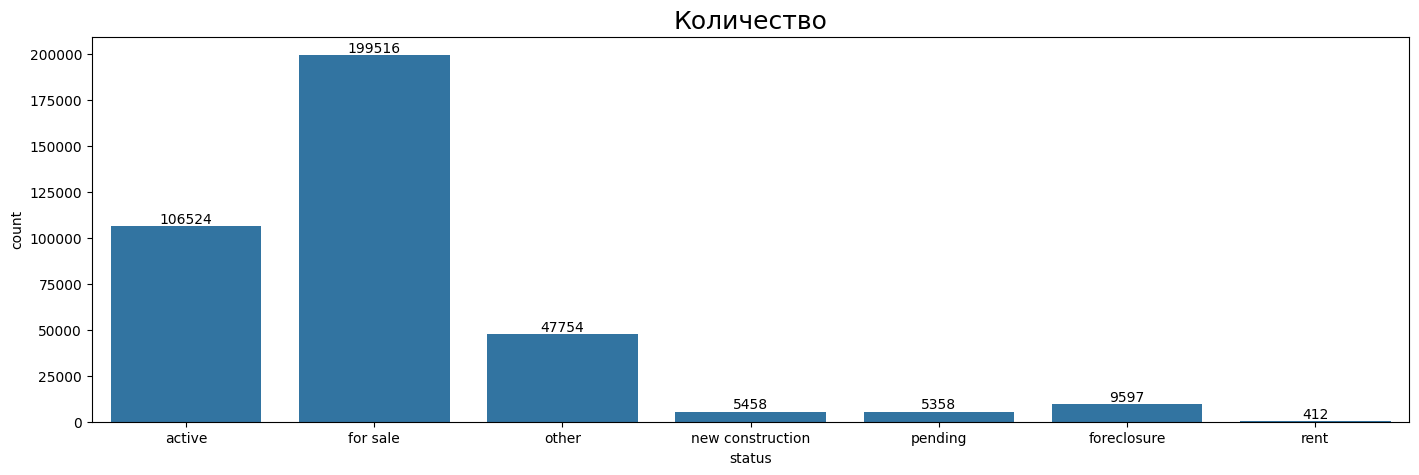

In [53]:
plt.figure(figsize=(17,5))
plt.title('Количество', fontsize=18)
ax = sns.countplot (x='status', data=data)
for i in ax.containers:
    ax.bar_label(i)
plt.show()

Исходя из базы данных, агентсво недвижимости в подавляющем большинстве занимается продажей - нежели арендой.

Переходим к признаку тип недвижимости - propertyType

In [54]:
data['propertyType'] = data['propertyType'].str.lower()
data['propertyType'] = data['propertyType'].str.replace('-', ' ')
propertyType = data.propertyType.value_counts(normalize=True)
propertyType.head(30)

propertyType
single family home               0.361960
single family                    0.181977
condo                            0.124588
lot/land                         0.060294
townhouse                        0.053943
land                             0.032076
multi family                     0.031365
condo/townhome/row home/co op    0.022643
traditional                      0.017385
coop                             0.009598
high rise                        0.005396
ranch                            0.005237
detached, one story              0.004746
mobile/manufactured              0.004743
single detached, traditional     0.004649
contemporary                     0.004576
multi family home                0.004414
1 story                          0.003632
colonial                         0.003540
mobile / manufactured            0.003105
contemporary/modern              0.002941
2 stories                        0.002679
apartment                        0.002344
mfd/mobile home      

In [55]:
# Унифицируем тип недвижимости
data.loc[data['propertyType'].str.contains('condo', case=False, na=False, regex=True), 'propertyType'] = 'condo'
data.loc[data['propertyType'].str.contains('ranch', case=False, na=False, regex=True), 'propertyType'] = 'ranch'
data.loc[data['propertyType'].str.contains('mobile', case=False, na=False, regex=True), 'propertyType'] = 'mobile'
data.loc[data['propertyType'].str.contains('coop', case=False, na=False, regex=True), 'propertyType'] = 'coop'
data.loc[data['propertyType'].str.contains('co op', case=False, na=False, regex=True), 'propertyType'] = 'coop'
data.loc[data['propertyType'].str.contains('high', case=False, na=False, regex=True), 'propertyType'] = 'high'
data.loc[data['propertyType'].str.contains('traditional', case=False, na=False, regex=True), 'propertyType'] = 'traditional'
data.loc[data['propertyType'].str.contains('resort', case=False, na=False, regex=True), 'propertyType'] = 'resort'
data.loc[data['propertyType'].str.contains('camp', case=False, na=False, regex=True), 'propertyType'] = 'resort'
data.loc[data['propertyType'].str.contains('contemporary', case=False, na=False, regex=True), 'propertyType'] = 'contemporary'
data.loc[data['propertyType'].str.contains('story', case=False, na=False, regex=True), 'propertyType'] = 'single family home'

In [56]:
# Подсчитываем количество значений NaN в столбце 'propertyType'
nan_count = data['propertyType'].isnull().sum()
print("Количество значений NaN в столбце '{}': {}".format('propertyType', nan_count))

Количество значений NaN в столбце 'propertyType': 34554


In [57]:
# Заполним пропуски типа недвижимости прочие
data['propertyType'] = data['propertyType'].fillna('other').astype(str)

Так как все типы недвижимости менее 0.004%, в большинстве своем, представляют стиль дома - переведем их в категорию single family home, за исключением резортов

In [58]:
# Подсчитываем количество каждого значения в столбце 'propertyType' и нормализуем
Type_counts = data['propertyType'].value_counts(normalize=True)
# Определяем пороговое значение для категории "other" (менее 0.004%)
threshold = 0.004
# Применяем условие для объединения значений (кроме 'resort'), которые составляют менее 0.004% от общего количества, в категорию "single family home"
data['propertyType'] = data['propertyType'].apply(lambda x: 'single family home' if Type_counts[x] < threshold and x != 'resort' else x)

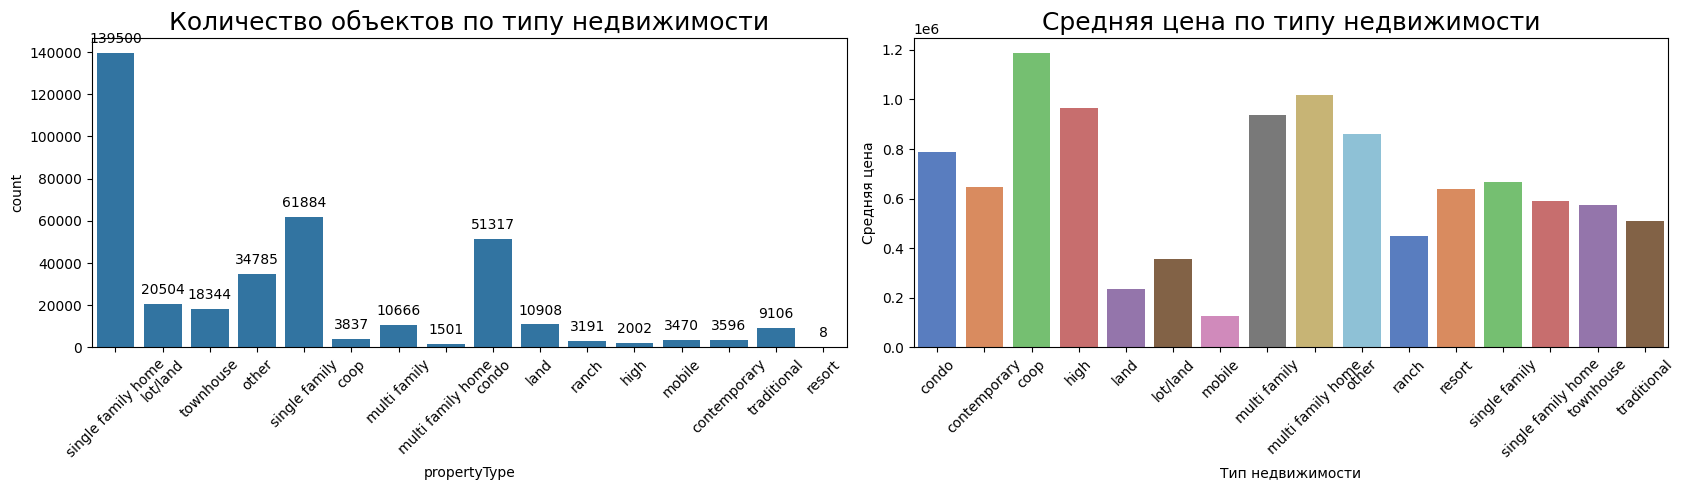

In [59]:
# Рассчитываем среднюю цену по типу недвижимости
avg_price_by_property_type = data.groupby('propertyType')['price'].mean()

# Строим графики
plt.figure(figsize=(17, 5))

# Первый график - количество объектов
plt.subplot(1, 2, 1)
plt.title('Количество объектов по типу недвижимости', fontsize=18)
ax1 = sns.countplot(x='propertyType', data=data)
for i in ax1.patches:
    ax1.annotate(format(i.get_height(), '.0f'), (i.get_x() + i.get_width() / 2., i.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.xticks(rotation=45)  # Вращение подписей оси x

# Второй график - средняя цена
plt.subplot(1, 2, 2)
plt.title('Средняя цена по типу недвижимости', fontsize=18)
sns.barplot(x=avg_price_by_property_type.index, y=avg_price_by_property_type.values, palette='muted')
plt.xlabel('Тип недвижимости')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Переходим к признаку площадь

In [60]:
# Удаление слов из столбца и преобразование в числовой формат
data['sqft'] = data['sqft'].str.lower()
data['sqft'] = data['sqft'].str.replace(r"[^\d\.]", "", regex=True)
data['sqft'] = pd.to_numeric(data['sqft'].str.strip().replace('', '0'), errors='coerce').fillna(0).astype(int)

In [61]:
# Подсчитываем количество значений NaN в столбце 'sqft'
nan_count = data['sqft'].isnull().sum()
print("Количество значений NaN в столбце '{}': {}".format('sqft', nan_count))

Количество значений NaN в столбце 'sqft': 0


In [62]:
# Подсчитываем количество каждого значения в столбце 'sqft'
sqft_counts = data['sqft'].value_counts()

# Удаляем строки, где значение в столбце 'sqft' равно 0
data = data[data['sqft'] != 0]

In [63]:
min_sqft = data['sqft'].min()
max_sqft = data['sqft'].max()

print("Минимальное значение sqft:", min_sqft)
print("Максимальное значение sqft:", max_sqft)

Минимальное значение sqft: 1
Максимальное значение sqft: 795979430


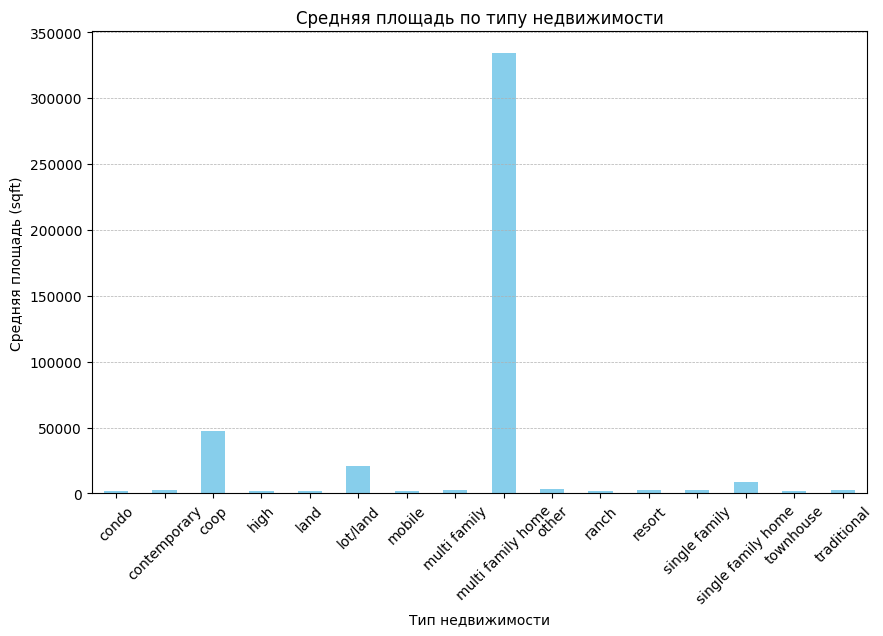

In [64]:
# Группируем данные по 'propertyType' и вычисляем среднюю площадь 'sqft'
avg_sqft_by_property_type = data.groupby('propertyType')['sqft'].mean()

# Строим график
plt.figure(figsize=(10, 6))
avg_sqft_by_property_type.plot(kind='bar', color='skyblue')
plt.title('Средняя площадь по типу недвижимости')
plt.xlabel('Тип недвижимости')
plt.ylabel('Средняя площадь (sqft)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

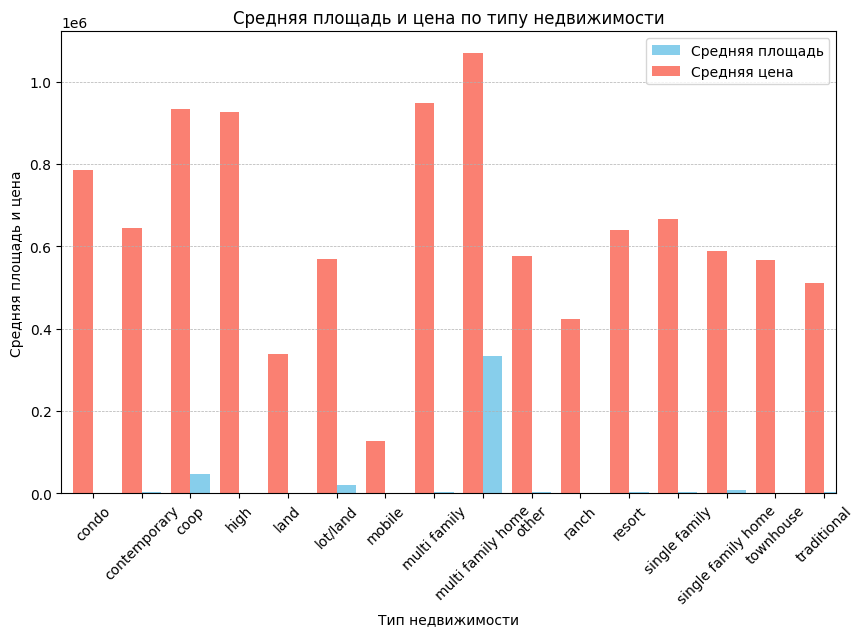

In [65]:
# Группируем данные по 'propertyType' и вычисляем среднюю площадь 'sqft' и среднюю цену 'price'
avg_data_by_property_type = data.groupby('propertyType').agg({'sqft': 'mean', 'price': 'mean'})

# Строим график
plt.figure(figsize=(10, 6))
avg_data_by_property_type['sqft'].plot(kind='bar', color='skyblue', position=0, width=0.4, label='Средняя площадь')
avg_data_by_property_type['price'].plot(kind='bar', color='salmon', position=1, width=0.4, label='Средняя цена')
plt.title('Средняя площадь и цена по типу недвижимости')
plt.xlabel('Тип недвижимости')
plt.ylabel('Средняя площадь и цена')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

Обратим внимание на почтовый индекс

In [66]:
# Унифицируем почтовый индекс и удалим строки, где индекс меньше пятизначного значения
data.zipcode = data.zipcode.str.replace('27616-6802', '27616')
data.zipcode = data.zipcode.str.replace('00000', '0')
data = data[data['zipcode'].str.len() == 5]

In [67]:
# Приведем все к нижнему регистру
data['city'] = data['city'].str.lower()
# Приведем все к верхнему регистру
data['state'] = data['state'].str.upper()

In [68]:
# Группировка данных по столбцам 'state', 'city' и 'zipcode' с подсчетом количества предложений
grouped_data = data.groupby(['state', 'city', 'zipcode']).size().reset_index(name='offer_count')
grouped_data

,state,city,zipcode,offer_count
0,AZ,avondale,85323,36
1,AZ,avondale,85392,24
2,AZ,buckeye,85326,117
3,AZ,buckeye,85396,74
4,AZ,el mirage,85335,89
...,...,...,...,...
5302,WI,milwaukee,53209,113
5303,WI,milwaukee,53212,124
5304,WI,milwaukee,53217,1
5305,WI,river hills,53217,30


Из группировки мы видим - что один почтовый индекс может приходится на два разных города, поэтому индекс мы не можем использовать, как ориентир

In [69]:
# Для каждого штата рассчитываем количество уникальных 'city' и 'zipcode'
unique_values_count = grouped_data.groupby('state').agg({'city': 'nunique', 'zipcode': 'nunique'})
unique_values_count 

,city,zipcode
state,,
AZ,15,59
BA,1,1
CA,249,651
CO,40,133
DC,1,22
DE,1,2
FL,247,444
GA,54,110
IA,23,23


Как видно в каждом штате есть разное количество городов, и еще больше почтовых индексов. Посмотрим на распределение объектов по штатам:

In [70]:
state = data.state.value_counts(normalize=True)
state.head(30)

state
FL    0.301144
TX    0.232871
CA    0.068036
NC    0.054662
NY    0.054618
TN    0.044593
WA    0.038813
OH    0.033759
NV    0.023990
IL    0.022996
CO    0.018560
GA    0.017813
PA    0.015867
MI    0.014796
DC    0.013571
AZ    0.009813
IN    0.009116
OR    0.008094
UT    0.003771
MD    0.003327
MO    0.002534
VA    0.002074
MA    0.001634
WI    0.001290
IA    0.000640
VT    0.000490
NJ    0.000422
KY    0.000216
ME    0.000203
OK    0.000094
Name: proportion, dtype: float64

Флорида и Техас - занимают больше половины объектов недвижимости. Можно было бы остановиться на Орландо, а остальные перевсти в прочие - но мы пойдем другим путем.

Посмотрим на признак адреса

In [71]:
data.street.value_counts().head(20)

street
Address Not Disclosed          594
Undisclosed Address            400
(undisclosed Address)          335
Address Not Available          126
Unknown Address                 61
2103 E State Hwy 21             57
11305 Gulf Fwy                  54
17030 Youngblood Rd.            38
9470 Lancaster Rd. SW           32
1 Palmer Dr                     27
8426 Terrace Valley Circle      25
9845 Basil Western Rd NW        25
6320 SW 89th Court Road         24
8447 SW 99th Street Rd          22
Whitetail Trail                 19
5221 S. Zapata Hwy              19
Stone Bluff Drive               18
2005 West Happy Valley Road     17
1727 Opal Field Lane            17
Boncher Blvd                    17
Name: count, dtype: int64

In [72]:
# Заменим отсутствующие улицы на 'USA'
data.loc[data['street'].str.contains('Address', case=False, na=False, regex=True), 'street'] = 'USA'

In [73]:
# Обработка пропущенных значений в столбце 'street'
data['street'].fillna('USA', inplace=True)
# Удаление строк, содержащих 'USA' в столбце 'street'
data = data[~data['street'].str.contains('USA')]
# Сброс индексов после удаления строк
data.reset_index(drop=True, inplace=True)

In [74]:
# Создание нового признака address
data['address'] = data[['street','city', 'state']].apply(lambda x: ', '.join(x), axis=1)

In [75]:
data.address.nunique()

284935

Итого у нас есть почти 285 тысяч уникальных адресов

In [76]:
# Создадим новый датафрейм из уникальных значений адресов
df_unique = pd.DataFrame()
df_unique['address'] = data['address'].unique()
df_unique.address.nunique()

284935

С помощью библиотеки geopy.geocoders получим координаты наших объектов, чтобы унифицировать объекты недвижимости - вместо отдельных четырех признаков получим два, т.к. местоположение является одним из главных признаков стоимости недвижимости

In [340]:
from geopy.geocoders import Nominatim

# Создаем экземпляр геокодера
geolocator = Nominatim(user_agent="wizardtver1977@gmail.com")

def service_geocode(g_locator, address):
    location = g_locator.geocode(address,timeout = 60)
    if location!=None:
      return (location.latitude, location.longitude)
    else:
      return np.NaN

In [146]:
df_unique['LAT_LON'] = df_unique['address'].apply(lambda x:service_geocode(geolocator,x))
df_unique[['address','LAT_LON']].head()

,address,LAT_LON
0,"240 Heather Ln, southern pines, NC",NaN
1,"12911 E Heroy Ave, spokane valley, WA","(47.699473, -117.23126635538125)"
2,"2005 Westridge Rd, los angeles, CA","(34.07140326443591, -118.5006544602982)"
3,"4311 Livingston Ave, dallas, TX","(32.83484935161085, -96.80742611392908)"
4,"1624 S Newkirk St, philadelphia, PA","(39.932969, -75.1920628239543)"


In [147]:
df_unique.to_csv('PRL_address.csv', index=False)

In [77]:
df_unique = pd.read_csv('PRL_address.csv')

так как этот процесс достаточно длительный - можно перейти к обновленному датафрейму в середине проекта, где пойдет работа с пропусками и графиками

In [78]:
# Преобразование данных в столбце 'LAT_LON' в строковый формат
df_unique['LAT_LON'] = df_unique['LAT_LON'].astype(str)

# Разделение столбца 'LAT_LON' на 'lat' и 'lng'
df_unique[['lat', 'lng']] = df_unique['LAT_LON'].str.strip('()').str.split(', ', expand=True).astype(float)

# Сравнение столбцов 'address' и перенос 'lat' и 'lng' в датафрейм 
for index, row in df_unique.iterrows():
    mask = data['address'] == row['address']
    if not mask.empty and mask.any():
        data.loc[mask, ['lat', 'lng']] = row['lat'], row['lng']

In [95]:
data.lat.isnull().sum()

102374

Видим, что не все адреса были найдены, поэтому для ненайденых геоточек адресов - подготовим геоточки центров городов

In [79]:
data['address_centr'] = data[['city', 'state']].apply(lambda x: ', '.join(x) + ', USA', axis=1)

Всего у нас получилось 1835 уникальных геоточек по центрам городов

In [80]:
data.address_centr.nunique()

1835

In [81]:
# Сформируем датафрейм для центров городов
df_centr = pd.DataFrame()
df_centr['address_centr'] = data['address_centr'].unique()

Как и ранее, воспользуемся библиотекой geopy.geocoder

In [64]:
df_centr['LAT_LON_centr'] = df_centr['address_centr'].apply(lambda x:service_geocode(geolocator,x))
df_centr[['address_centr','LAT_LON_centr']].head()

,address_centr,LAT_LON_centr
0,"southern pines, NC, USA","(35.1740471, -79.3922539)"
1,"spokane valley, WA, USA","(47.6571104, -117.2613936)"
2,"los angeles, CA, USA","(34.0536909, -118.242766)"
3,"dallas, TX, USA","(32.7762719, -96.7968559)"
4,"philadelphia, PA, USA","(39.9527237, -75.1635262)"


In [65]:
# Сохраним себе датафрейм с геоточками
df_centr.to_csv('PRL_address_centr.csv', index=False)

In [82]:
df_centr = pd.read_csv('PRL_address_centr.csv')

In [83]:
# Преобразование данных в столбце 'LAT_LON_centr' в строковый формат
df_centr['LAT_LON_centr'] = df_centr['LAT_LON_centr'].astype(str)

# Разделение столбца 'LAT_LON_centr' на 'lat_centr' и 'lng_centr'
df_centr[['lat_centr', 'lng_centr']] = df_centr['LAT_LON_centr'].str.strip('()').str.split(', ', expand=True).astype(float)

# Сравнение столбцов 'address_centr' и перенос 'lat_centr' и 'lng_centr' в датафрейм
for index, row in df_centr.iterrows():
    mask = data['address_centr'] == row['address_centr']
    if not mask.empty and mask.any():
        data.loc[mask, ['lat_centr', 'lng_centr']] = row['lat_centr'], row['lng_centr']

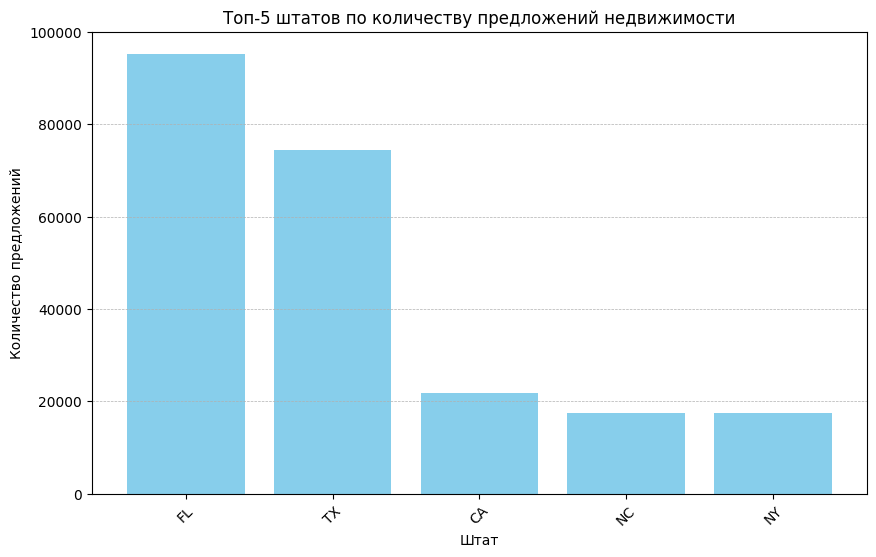

In [84]:
# Группировка данных по штатам с подсчетом количества предложений
grouped_states = data.groupby('state').size().reset_index(name='offer_count')

# Сортировка данных по количеству предложений в убывающем порядке
top_states = grouped_states.sort_values(by='offer_count', ascending=False).head(5)

# Строим график
plt.figure(figsize=(10, 6))
plt.bar(top_states['state'], top_states['offer_count'], color='skyblue')
plt.title('Топ-5 штатов по количеству предложений недвижимости')
plt.xlabel('Штат')
plt.ylabel('Количество предложений')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

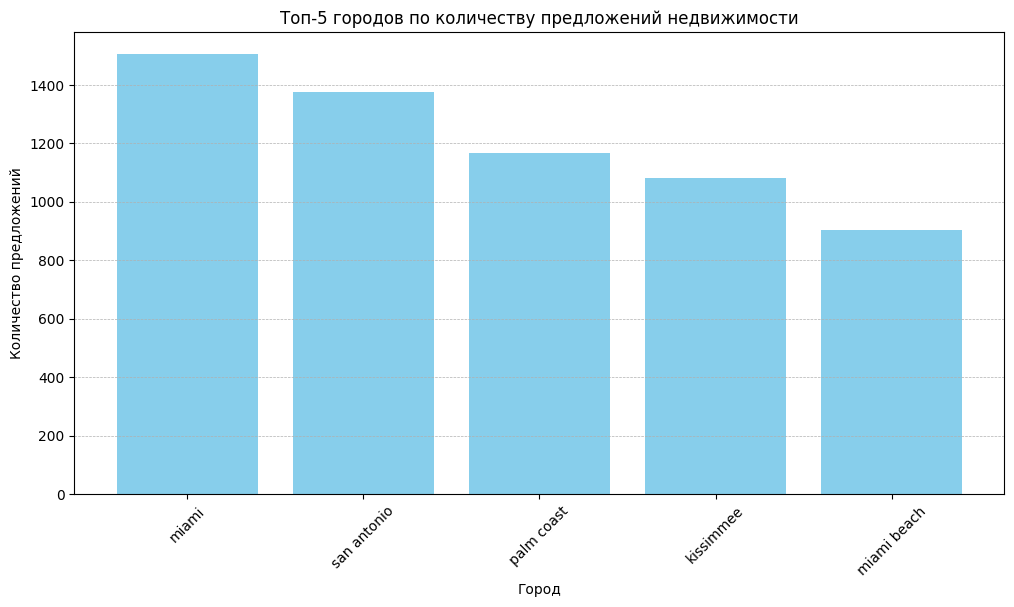

In [85]:
top_cities = grouped_data.sort_values(by='offer_count', ascending=False).head(10)

# Строим график
plt.figure(figsize=(12, 6))
plt.bar(top_cities['city'], top_cities['offer_count'], color='skyblue')
plt.title('Топ-5 городов по количеству предложений недвижимости')
plt.xlabel('Город')
plt.ylabel('Количество предложений')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [86]:
# Группировка данных по 'state', 'city', 'zipcode' и 'propertyType' с подсчетом количества предложений и средней цены
grouped = data.groupby(['state', 'city', 'zipcode','status','propertyType']).agg({'price': 'mean'}).reset_index()
grouped_d = grouped.rename(columns={'status':'status_counts','propertyType': 'offer_count', 'price': 'average_price'})
grouped_d.head(25) 

,state,city,zipcode,status_counts,offer_count,average_price
0,AZ,avondale,85323,active,single family home,264187.366667
1,AZ,avondale,85323,other,single family home,234950.000000
2,AZ,avondale,85323,pending,single family home,252450.000000
3,AZ,avondale,85392,active,single family home,284371.933333
4,AZ,avondale,85392,other,single family home,263300.000000
5,AZ,avondale,85392,pending,single family home,278116.666667
6,AZ,buckeye,85326,active,mobile,133167.187500
7,AZ,buckeye,85326,active,single family home,282194.622222
8,AZ,buckeye,85326,other,single family home,220978.000000
9,AZ,buckeye,85326,pending,single family home,234414.000000


Из таблицы видно, что цены в одном и том же городе, с разными почтовыми индексами, статусом и типом недвижимости имеют разную цену. Запомним это.

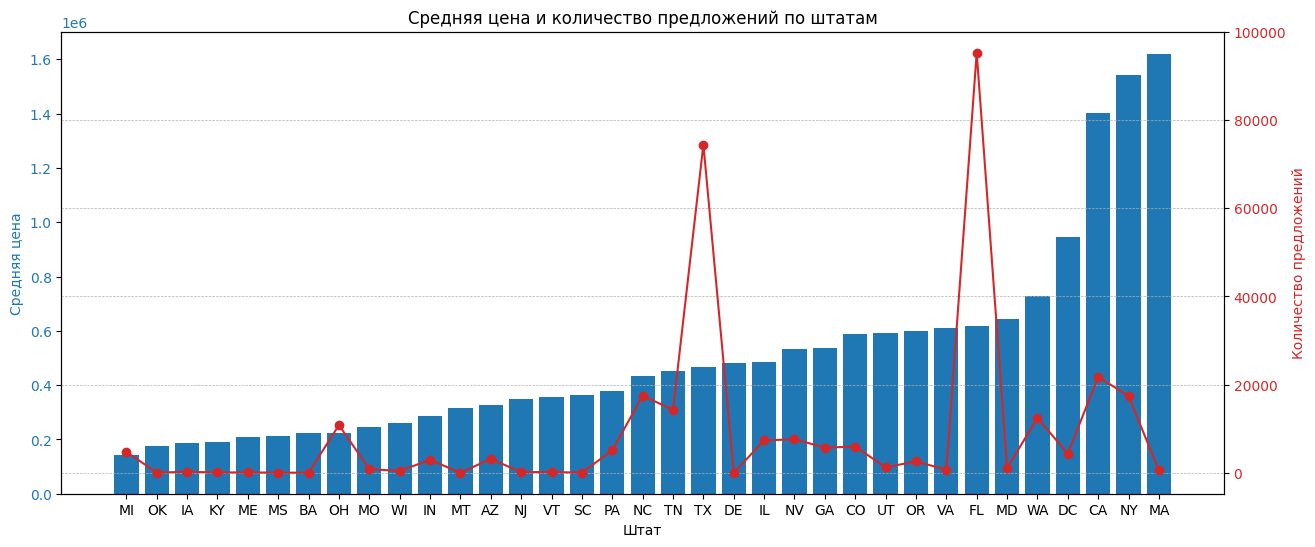

In [87]:
# Добавляем столбец 'offer_count', который содержит количество предложений для каждой строки
data['offer_count'] = 1

# Рассчитываем среднюю цену и количество предложений по каждому штату
avg_price_and_count_by_state = data.groupby('state').agg({'price': 'mean', 'offer_count': 'sum'}).sort_values(by='price')

# Строим график
fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:blue'
ax1.set_xlabel('Штат')
ax1.set_ylabel('Средняя цена', color=color)
ax1.bar(avg_price_and_count_by_state.index, avg_price_and_count_by_state['price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Количество предложений', color=color)
ax2.plot(avg_price_and_count_by_state.index, avg_price_and_count_by_state['offer_count'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Средняя цена и количество предложений по штатам')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

In [88]:
# Переименуем год постройки
data.rename(columns={'year built': 'year_built'}, inplace=True)

In [89]:
# Заполним пропуски значением 'no'
data['year_built'] = data['year_built'].fillna('no').astype(str)

In [90]:
# Посмотрим на уникальные значения признака
data.year_built.unique()

array(['2019', '1961', '2006', '1920', '1970', '1965', '2015', '1996',
       '1982', '2008', '1899', '2016', '1954', '1989', '2014', '1915', '',
       '1994', '1910', '1923', '1960', '1977', '1972', '1963', '1981',
       '1949', '1930', '1991', '1958', '2005', '2017', '2018', '1983',
       '1928', '1997', '1964', '1974', '1940', '1973', '1968', '1918',
       '2007', '1984', '1946', '2003', '2000', '2004', '1969', '2002',
       '1999', '1952', '1947', '1957', '1978', '1956', '1967', '1975',
       '1988', '1955', '1950', '1959', '2012', '1924', '1966', '1992',
       '2001', '1995', '2010', '1971', '1909', '1953', '1993', '1990',
       '1998', '1980', '1985', '1951', '1907', '1885', '1941', '1927',
       '1929', '1901', '1976', '1922', '1906', '1945', '1979', '2009',
       '1962', '0', '1913', '2011', '1897', '1987', '2020', '1926',
       '1939', '1925', '2013', '1943', '1935', '1890', '1895', '1911',
       '1948', 'no data', '1942', '1916', '1900', '1986', '1931', '1944',
  

In [91]:
# Переименуем неподходящие значения на удобоваримые
data.year_built.replace({'no':'0', '1019':'1910','559990649990':'1990','1':'0','no data':'0','1057':'1750','1208':'1802','':'0'}, inplace=True)

In [92]:
# переведем все в числовой формат
data['year_built'] = data['year_built'].astype(int)

In [93]:
# Группировка данных по 'state', 'city', 'zipcode', 'status', 'propertyType' и 'year_built' с вычислением средней цены
group = data.groupby(['state', 'city', 'zipcode', 'status', 'propertyType', 'year_built']).agg({'price': 'mean'}).reset_index()
grouped_y = group.rename(columns={'status': 'status_counts', 'propertyType': 'offer_count', 'price': 'average_price'})
grouped_y

,state,city,zipcode,status_counts,offer_count,year_built,average_price
0,AZ,avondale,85323,active,single family home,0,270640.000000
1,AZ,avondale,85323,active,single family home,1991,134900.000000
2,AZ,avondale,85323,active,single family home,1995,199900.000000
3,AZ,avondale,85323,active,single family home,2003,266466.666667
4,AZ,avondale,85323,active,single family home,2004,229966.666667
...,...,...,...,...,...,...,...
166817,WI,whitefish bay,53217,active,single family home,1948,549900.000000
166818,WI,whitefish bay,53217,active,single family home,1950,344450.000000
166819,WI,whitefish bay,53217,active,single family home,1951,240000.000000
166820,WI,whitefish bay,53217,active,single family home,1952,399950.000000


Как видим из таблицы - цены разнятся, в зависимости от года

In [94]:
year_counts = data['year_built'].value_counts().sort_index(ascending=True)
year_counts

year_built
0       19321
1060        1
1700        1
1703        2
1750        2
        ...  
2019    30961
2020     2349
2021       55
2022        8
2025        2
Name: count, Length: 219, dtype: int64

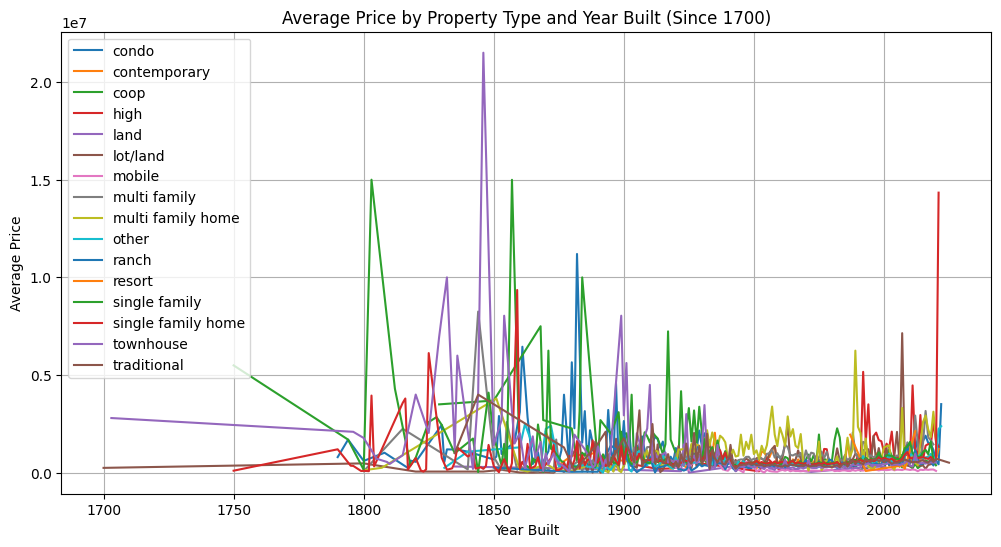

In [291]:
# Фильтрация данных для годов с 1700 и позже
data_filtered = data[data['year_built'] >= 1700]

# Группировка отфильтрованных данных по 'propertyType', 'year_built' с вычислением средней цены
grouped_year = data_filtered.groupby(['propertyType', 'year_built']).agg({'price': 'mean'}).reset_index()

# Построение графика
plt.figure(figsize=(12, 6))
for property_type in grouped_year['propertyType'].unique():
    subset = grouped_year[grouped_year['propertyType'] == property_type]
    plt.plot(subset['year_built'], subset['price'], label=property_type)

plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.title('Average Price by Property Type and Year Built (Since 1700)')
plt.legend()
plt.grid(True)
plt.show()

По данному графику можно написать отдельную работу - а именно по типу недвижимости в перспективе, поэтому оставим его как есть для наглядности

In [292]:
year_built = data.year_built.value_counts(normalize=True)
year_built.head(30)

year_built
2019    0.097185
0       0.060648
2006    0.024456
2005    0.022757
2007    0.021659
2018    0.020535
2004    0.016690
2017    0.015632
2016    0.015415
2008    0.015177
2003    0.013824
1950    0.013425
2002    0.012898
2001    0.012750
1920    0.012700
1925    0.012546
2015    0.011815
1955    0.010964
2000    0.010927
1960    0.010792
1974    0.010286
1999    0.010274
1973    0.010224
1979    0.010139
1972    0.009859
1980    0.009841
1981    0.009809
2014    0.009470
1984    0.009436
1998    0.009395
Name: proportion, dtype: float64

Больше всего данных по объектам недвижимости за 2019 год, чуть больше 6% - объекты без данных о годе.

In [96]:
# Фильтрация данных, группировка и подсчет
filtered_data = data[data['year_built'] == 0]
year_data = filtered_data.groupby(['year_built', 'propertyType']).size().reset_index(name='count_properties')
year_data

,year_built,propertyType,count_properties
0,0,condo,1323
1,0,contemporary,27
2,0,coop,49
3,0,lot/land,770
4,0,mobile,33
5,0,multi family,92
6,0,multi family home,13
7,0,other,989
8,0,ranch,15
9,0,single family,942


Можно сказать, что более 10% тип недвижимости single family home - без данных о годе постройки, если земля и часть земли, по большей части не интересны с данной информацией - то для капитальных строений - это критично. Но так как база данных не содержит признака состояние объекта - то не будем уделять этому пристального внимания.

In [97]:
# Переименуем год перестройки
data.rename(columns={'remodeled year': 'remodeled'}, inplace=True)

In [98]:
# посмотрим на уникальные значения данного признака
data.remodeled.unique()

array(['', '1967', '2006', 0, '2015', '1997', '2019', '1982', '2009',
       '2007', '1996', '1995', '1988', '1972', '1949', '1954', '1930',
       '2000', '1994', '2005', '1983', '2003', '1965', '1968', '1993',
       '1999', '2014', '2008', '2010', '2004', '2002', '1952', '1978',
       '1975', '1971', '1947', '1957', '1950', '1973', '1970', '2016',
       '1989', '1998', '1980', '1955', '1991', '2011', '2017', '1986',
       '1941', '2001', '1990', '1979', '1901', '1984', '1918', '1977',
       '1962', '1956', '2013', '1960', '1981', '1969', '1987', '1958',
       '1910', '1925', '1964', '1966', '1992', '1943', '1961', '1948',
       '1931', '2012', '1976', '1974', '1935', '1940', '2018', '1916',
       '1914', '1963', '1985', '1951', '1942', '1959', '1927', '1946',
       '1944', '1945', '1920', '1938', '1936', '0', '1939', '1915',
       '1928', '1923', '1929', '1898', '1899', '1934', '1953', '1926',
       '1937', '1912', '1917', '1906', '1932', '1905', '1919', '1921',
       '19

In [99]:
# Избавимся от кривых данных
data.remodeled.replace({'1111':'0', '':'0'}, inplace=True)

In [100]:
# переведем все в числовой формат
data['remodeled'] = data['remodeled'].astype(int)

In [101]:
remodeled = data.remodeled.value_counts(normalize=True)
remodeled.head(30)

remodeled
0       0.539993
2006    0.017051
2005    0.014725
2007    0.013388
2008    0.011580
2004    0.010299
1980    0.010224
1970    0.009593
2000    0.009411
2003    0.008645
1985    0.008601
2002    0.008321
1975    0.008259
1990    0.008171
1965    0.008004
1983    0.007581
2001    0.007533
1995    0.007339
1988    0.007194
1978    0.006815
1962    0.006802
1981    0.006589
1998    0.006538
1999    0.006381
1960    0.006278
1982    0.006225
2014    0.006162
1972    0.006058
1984    0.005970
1996    0.005876
Name: proportion, dtype: float64

Почти 54% недвижимости не перестраивались, остальные 46% имели такую возможность обновиться

In [102]:
# заполним пропуски на 'no'
data['heating'] = data['heating'].replace(np.nan, 'no')

In [103]:
# заполним пробелы и нули на 'no'
data.heating.replace({'':'no','0':'no'}, inplace=True)

In [104]:
heating = data.heating.value_counts(normalize=True)
heating.head(30)

heating
forced air                     0.408559
no                             0.202299
other                          0.088547
heat pump                      0.027121
no data                        0.025498
gas                            0.023115
electric                       0.022987
central electric               0.022196
central air                    0.021452
central                        0.019327
central, electric              0.013228
baseboard                      0.011027
wall                           0.010004
electric heat                  0.009586
heating system                 0.008503
forced air, heat pump          0.005490
radiant                        0.004429
natural gas heat               0.004313
central air, ceiling fan(s)    0.004049
central furnace                0.003148
forced air, gas                0.002853
central electric, zoned        0.002737
forced air heating             0.002511
, gas hot air/furnace          0.002430
gas heat                       0

Основным источником тепла является нагнетаемый воздух, чуть больше 20% его отсутствие - да и в жарких штатах оно ни к чему. Остальное это источники нагнетения. Поэтому в последствии мы все изменим, а пока структурируем, как есть

In [105]:
data.loc[data['heating'].str.contains('air', case=False, na=False, regex=True), 'heating'] = 'forced air'
data.loc[data['heating'].str.contains('heat', case=False, na=False, regex=True), 'heating'] = 'forced air'
data.loc[data['heating'].str.contains('gas', case=False, na=False, regex=True), 'heating'] = 'gas'
data.loc[data['heating'].str.contains('propane', case=False, na=False, regex=True), 'heating'] = 'gas'
data.loc[data['heating'].str.contains('electric', case=False, na=False, regex=True), 'heating'] = 'electric'
data.loc[data['heating'].str.contains('no', case=False, na=False, regex=True), 'heating'] = 'no'
data.loc[data['heating'].str.contains('central', case=False, na=False, regex=True), 'heating'] = 'central'

In [106]:
# Подсчитываем количество каждого значения в столбце 'heating' и нормализуем
heating_counts = data['heating'].value_counts(normalize=True)
# Определяем пороговое значение для категории "Other" (менее 0.02%)
threshold = 0.02
# Применяем условие для объединения значений, которые составляют менее 0.02% от общего количества, в категорию "Other"
data['heating'] = data['heating'].apply(lambda x: 'other' if heating_counts[x] < threshold else x)

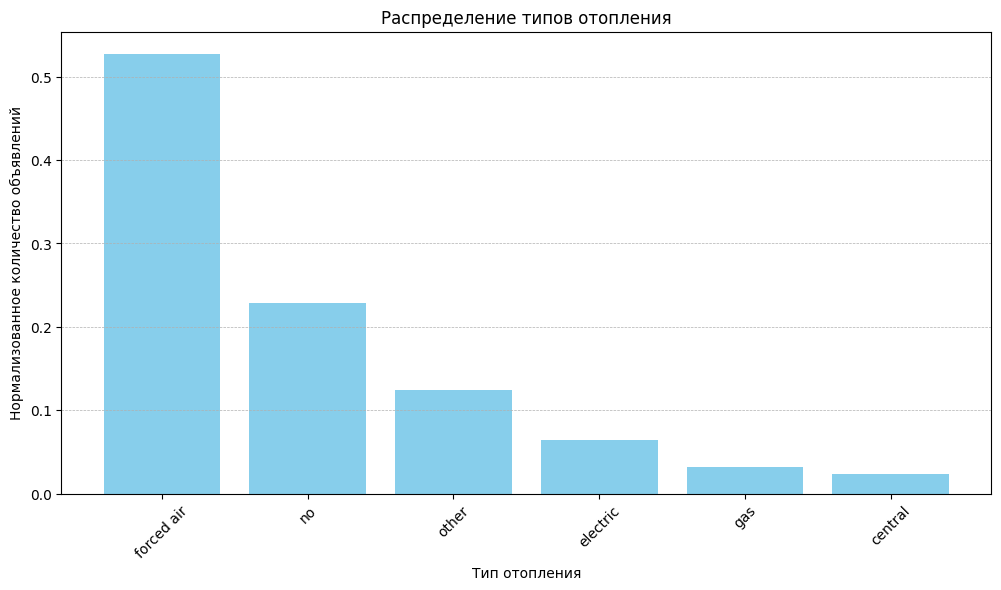

In [107]:
# Рассчитываем нормализованное количество объявлений по типу отопления
heating = data.heating.value_counts(normalize=True)

# Строим график
plt.figure(figsize=(12, 6))
plt.bar(heating.index, heating.values, color='skyblue')
plt.xlabel('Тип отопления')
plt.ylabel('Нормализованное количество объявлений')
plt.title('Распределение типов отопления')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

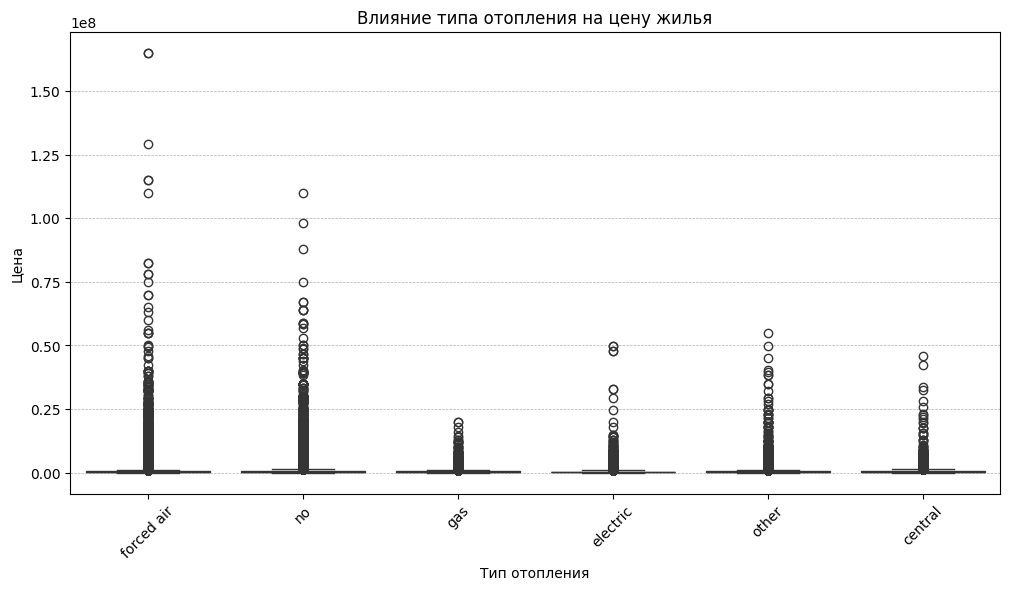

In [108]:
# Строим boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='heating', y='price', data=data, palette='viridis')
plt.xlabel('Тип отопления')
plt.ylabel('Цена')
plt.title('Влияние типа отопления на цену жилья')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

Видим множестов выбросов по каждому типу отопления.

In [113]:
avg_price_by_heating = data.groupby('heating')['price'].mean()
avg_price_by_heating

heating
central       722818.887331
electric      508158.516314
forced air    624107.423557
gas           544939.304904
no            772508.551327
other         546187.490777
Name: price, dtype: float64

Видно, что цены разняться между типами отопления - но отсутвие отопления еще больше поднимает цену. Запомним.

Проделаем предыдущую процедуру с отоплением приминительно к признаку охлаждение

In [114]:
# заполним пропуски на 'no'
data['cooling'] = data['cooling'].replace(np.nan, 'no')

In [115]:
# заполним пробелы и нули на 'no'
data.cooling.replace({'':'no','0':'no'}, inplace=True)

In [116]:
cooling = data.cooling.value_counts(normalize=True)
cooling.head(30)

cooling
central           0.625561
no                0.261427
other             0.076917
cooling_system    0.036095
Name: proportion, dtype: float64

Как видно - больше 48% это сентральное охлаждение, но оно все равно сводится к нагнетаемому воздуху. Больше 25% - это отсутвие охлаждения, видимо северные штаты. Оставшиеся это источники нагнетания. Поэтому - унифицируем, как есть

In [110]:
data.loc[data['cooling'].str.contains('no', case=False, na=False, regex=True), 'cooling'] = 'no'
data.loc[data['cooling'].str.contains('central', case=False, na=False, regex=True), 'cooling'] = 'central'
data.loc[data['cooling'].str.contains('cooling', case=False, na=False, regex=True), 'cooling'] = 'cooling_system'

In [111]:
# Подсчитываем количество каждого значения в столбце 'cooling' и нормализуем
cooling_counts = data['cooling'].value_counts(normalize=True)
# Определяем пороговое значение для категории "Other" (менее 0.03%)
threshold = 0.03
# Применяем условие для объединения, которые составляют менее 0.03% от общего количества, в категорию "Other"
data['cooling'] = data['cooling'].apply(lambda x: 'other' if cooling_counts[x] < threshold else x)

In [117]:
avg_price_by_cooling = data.groupby('cooling')['price'].mean()
avg_price_by_cooling

cooling
central           653652.718360
cooling_system    802310.197061
no                635864.692442
other             474691.638957
Name: price, dtype: float64

Видим, что цены - кто в лес, кто по дрова. Позже унифицируем еще раз.

Паркинг

In [118]:
# заполним пропуски на 'no'
data['parking'] = data['parking'].replace(np.nan, 'no')

In [119]:
# заменим значения
data.parking.replace({'':'no','0':'no','1':'parking space','2':'parking space','3':'parking space','4':'parking space',
                      '5':'parking space','6':'parking space','7':'parking space','8':'parking space','888':'parking space'}, inplace=True)

In [120]:
parking = data.parking.value_counts(normalize=True)
parking.head(30)

parking
no                                  0.396622
attached garage                     0.216813
2 spaces                            0.086202
1 space                             0.043258
detached garage                     0.039843
no data                             0.039055
carport                             0.023677
parking space                       0.022566
off street                          0.015980
3 spaces                            0.014508
4 spaces                            0.008871
carport, attached garage            0.008761
on street                           0.005076
attached garage, detached garage    0.004165
attached garage, carport            0.002853
parking desc                        0.002816
6 spaces                            0.002288
detached garage, attached garage    0.002247
driveway                            0.002000
5 spaces                            0.002000
off street parking                  0.001795
0                                   0.001704
of

Почти 40% - это объекты без парковки. Около 22% - имеют отдельный присоединенный гараж. Унифицируем данный признак

In [121]:
data.loc[data['parking'].str.contains('attached garage', case=False, na=False, regex=True), 'parking'] = 'attached garage'
data.loc[data['parking'].str.contains('garage-attached', case=False, na=False, regex=True), 'parking'] = 'attached garage'
data.loc[data['parking'].str.contains('detached garage', case=False, na=False, regex=True), 'parking'] = 'detached garage'
data.loc[data['parking'].str.contains('garage - 2 car', case=False, na=False, regex=True), 'parking'] = 'detached garage'
data.loc[data['parking'].str.contains('no', case=False, na=False, regex=True), 'parking'] = 'no'
data.loc[data['parking'].str.contains('space', case=False, na=False, regex=True), 'parking'] = 'parking space'
data.loc[data['parking'].str.contains('off street', case=False, na=False, regex=True), 'parking'] = 'off street'
data.loc[data['parking'].str.contains('on street', case=False, na=False, regex=True), 'parking'] = 'on street'

In [122]:
# Подсчитываем количество каждого значения в столбце 'parking' и нормализуем
parking_counts = data['parking'].value_counts(normalize=True)
# Определяем пороговое значение для категории "on street" (менее 0.006%)
threshold = 0.006
# Применяем условие для объединения, которые составляют менее 0.006% от общего количества, в категорию "on street"
data['parking'] = data['parking'].apply(lambda x: 'on street' if parking_counts[x] < threshold else x)

In [123]:
avg_price_by_parking = data.groupby('parking')['price'].mean()
avg_price_by_parking

parking
attached garage    698263.192608
carport            453733.666048
detached garage    562597.914280
no                 621105.985594
off street         591343.425241
on street          604866.770504
parking space      665567.662037
Name: price, dtype: float64

опять видим, что цены - кто куда. Позднее унифицируем и это признак

Приусадебный участок

In [124]:
data['lotsize'].isnull().sum()

0

In [125]:
lotsize = data.lotsize.value_counts(normalize=True)
lotsize.head(30)

lotsize
               0.093792
0              0.075655
—              0.051683
no data        0.016037
-- sqft lot    0.011457
0.26 acres     0.008328
0.28 acres     0.007129
0.27 acres     0.006752
0.25 acres     0.006573
0.29 acres     0.006187
0.34 acres     0.005236
6,098 sqft     0.004551
0.31 acres     0.004551
0.3 acres      0.004244
0.32 acres     0.004200
7,405 sqft     0.003983
6,534 sqft     0.003867
4,356 sqft     0.003833
0.33 acres     0.003817
0.35 acres     0.003616
10,000 sqft    0.003550
5,227 sqft     0.003503
5,000 sqft     0.003387
1 acre         0.003384
0.36 acres     0.003243
0.37 acres     0.003130
0.46 acres     0.003114
8,712 sqft     0.003064
3,920 sqft     0.002954
8,276 sqft     0.002913
Name: proportion, dtype: float64

Разноформатные данные - это мы изменим с помощью функции и приведем все к одному знаменателю - квадратные футы

In [126]:
# заменим пропуски, пробелы, тире и т.д. на '0'
data.lotsize.replace({'':'0','-- sqft lot':'0','—':'0','no data':'0','NaN':'0'}, inplace=True)

In [127]:
# избавимся от лишних слов и запятых
data.lotsize = data.lotsize.str.replace(',', '')
data.lotsize = data.lotsize.str.replace(' lot', '')
data.lotsize = data.lotsize.str.replace(' sqft', '')
data.lotsize = data.lotsize.str.replace(' sq. ft.', '')
data.lotsize = data.lotsize.str.replace(' acres', ' acre')

In [128]:
# Напишем функцию для перевода акров в квадратные футы
def convert_acres_to_sqft(value):
    if pd.isnull(value):
        return np.nan
    elif 'acre' in value:
        return int(float(value.replace(' acre', '')) * 43560)
    else:
        return value

# Применим функцию к признаку lotsize
data.lotsize = data.lotsize.apply(convert_acres_to_sqft)

In [129]:
# Заполним пропуски нулями
data['lotsize'] = data['lotsize'].replace(np.nan, '0')

In [130]:
# Переведем все в числовой формат
data.lotsize = data.lotsize.astype(int)

Посмотрим на крайние значения признака

In [131]:
min_lotsize = data['lotsize'].min()
max_lotsize = data['lotsize'].max()

print("Минимальное значение lotsize:", min_lotsize)
print("Максимальное значение lotsize:", max_lotsize)

Минимальное значение lotsize: -1742
Максимальное значение lotsize: 2147483606


In [132]:
# Избавимся от отрицательного значения
data['lotsize'] = data['lotsize'].replace(-1742, 1742)

Переходим к признаку - количество спален

In [133]:
# Удаление слов из столбца и преобразование в числовой формат
data['beds'] = data['beds'].str.lower()
data['beds'] = data['beds'].str.replace(r"[^\d\.]", "", regex=True)

In [134]:
data.beds.unique()

array(['4', '3', '5', '2', nan, '', '8', '2.0', '1', '3.0', '6', '12',
       '14', '7', '5.0', '4.0', '9', '0', '7.0', '1.0', '16', '6.0', '10',
       '18', '20', '32', '6351', '13', '0.0', '11', '26', '144', '22',
       '24', '15', '10.0', '8.0', '28', '36', '19', '48', '25', '17',
       '27', '1960', '40', '47', '23', '44', '12.0', '30.0', '33', '9.0',
       '13.0', '2250', '31', '16.0', '34', '30', '99', '2178',
       '3607312.2.', '11.0', '53', '27.0', '51', '60', '21', '75', '15.0',
       '29', '39', '42', '7082481.2.', '52', '76', '78', '35', '88',
       '4356'], dtype=object)

In [135]:
# Убираем кривые данные
data.beds.replace({'3607312.2.':'0','7082481.2.':'0'}, inplace=True)

In [136]:
# Заполняем как пропущенные значения (NaN), так и пустые строки в столбце 'beds' нулями
data['beds'].fillna(0, inplace=True)
data['beds'] = data['beds'].replace('', 0)

In [137]:
# Переведем сначала в формат флоат
data.beds = data.beds.astype(float)

In [138]:
# А теперь в чистый числовой формат
data.beds = data.beds.astype(int)

In [139]:
beds = data.beds.value_counts(normalize=True)
beds.head(10)

beds
3    0.322081
4    0.210981
0    0.199173
2    0.150629
5    0.066213
6    0.019524
1    0.018272
7    0.005418
8    0.003541
9    0.001372
Name: proportion, dtype: float64

Как видно - свыше 32% это объекты с тремя спальнями, свыше 21% 4 спальнями. Почти 20% - данные отсутсвуют, возможно часть нулей - это земля или часть земли. 15% 2 спальни.
Остальное - это либо все, либо ничего

Посмотрим на совсем уникальные объекты:

In [140]:
beds_gt_100 = data[data['beds'] > 100]
beds_gt_100

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,...,rating_schools,price,pool,address,lat,lng,address_centr,lat_centr,lng_centr,offer_count
2887,other,single family home,4665 14th Ave S,-- baths,saint petersburg,1076,33711,6351,FL,NaN,...,"[2/10, 2/10, 4/10]",20500,no,"4665 14th Ave S, saint petersburg, FL",NaN,NaN,"saint petersburg, FL, USA",27.770048,-82.635908,1
6171,active,multi family home,2202 Bristol Rd,2,laredo,62376,78045,144,TX,NaN,...,"[7, 8, 4, 8, 9, 6, NR, NR]",1590000,no,"2202 Bristol Rd, laredo, TX",27.583909,-99.515182,"laredo, TX, USA",27.505625,-99.507452,1
43137,foreclosure,single family home,313 Sherman St,2 baths,albany,1400,12206,1960,NY,NaN,...,"[2/10, 3/10, 3/10]",600,no,"313 Sherman St, albany, NY",42.665613,-73.772137,"albany, NY, USA",42.651167,-73.754968,1
80191,foreclosure,single family home,360 Sheridan Ave,-- baths,albany,1752,12206,2250,NY,NaN,...,"[1/10, 3/10, 3/10]",1000,no,"360 Sheridan Ave, albany, NY",42.660955,-73.765057,"albany, NY, USA",42.651167,-73.754968,1
104233,foreclosure,single family home,446 Elk St,2 baths,albany,1600,12206,2178,NY,NaN,...,"[2/10, 3/10, 3/10]",1000,no,"446 Elk St, albany, NY",42.665808,-73.771812,"albany, NY, USA",42.651167,-73.754968,1
308283,foreclosure,single family home,262 Franklin Blvd,-- baths,elgin,1652,60120,4356,IL,NaN,...,"[3/10, 3/10, 2/10]",5500,no,"262 Franklin Blvd, elgin, IL",42.042940,-88.280409,"elgin, IL, USA",42.037260,-88.281099,1


Как видно - только один объект из 6 более или менее адекватен - а остальные являются мусором, поэтому мы их удалим

In [141]:
data.loc[data['beds'] > 144, 'beds'] = data[data['beds'] > 144]['beds'].astype(str).str[0].astype(int)
# Сброс индексов после удаления строк
data.reset_index(drop=True, inplace=True)

Переходим к этажности домов

In [142]:
# Удаление слов из столбца и преобразование в числовой формат
data['stories'] = data['stories'].str.lower()
data['stories'] = data['stories'].str.replace(r"[^\d\.]", "", regex=True)

In [144]:
stories = data.stories.value_counts(normalize=True)
stories.head(20)

stories
1.0     0.298991
2.0     0.246581
1       0.110482
2       0.092216
        0.051252
3.0     0.049495
0.0     0.032341
3       0.023783
0       0.018897
9.0     0.012772
2.00    0.012137
4.0     0.009262
1.00    0.005294
4       0.004068
6.0     0.003133
1.50    0.002788
5.0     0.002647
3.00    0.002302
1.5     0.002166
9       0.002080
Name: proportion, dtype: float64

Свыше 41% - это одноэтажные дома, почти 34% являются двухэтажными, 7% - это трехэтажные, 5% не имеют этажности(скорее всего это земли)

In [145]:
# Заполняем как пропущенные значения (NaN), так и пустые строки в столбце 'stories' нулями
data['stories'].fillna(0, inplace=True)
data['stories'] = data['stories'].replace('', 0)

In [146]:
data.stories.replace({'1....':'1'}, inplace=True)

In [147]:
data.stories = data.stories.astype(float)

In [148]:
stories_30 = data[data['stories'] > 30]
stories_30

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,...,rating_schools,price,pool,address,lat,lng,address_centr,lat_centr,lng_centr,offer_count
826,for sale,condo,480 NE 31st St #605,3 Baths,miami,1322,33137,2,FL,54.0,...,"[2/10, 4/10, 10/10, 2/10, None/10]",999000,yes,"480 NE 31st St #605, miami, FL",25.806425,-80.187816,"miami, FL, USA",25.774173,-80.193620,1
2256,for sale,condo,900 Biscayne Blvd #2309,3 Baths,miami,1579,33132,2,FL,63.0,...,"[2/10, 3/10, 10/10, 2/10, None/10]",1180000,yes,"900 Biscayne Blvd #2309, miami, FL",25.784538,-80.189156,"miami, FL, USA",25.774173,-80.193620,1
5753,for sale,condo,1643 Brickell Ave APT 4301,7,miami,6300,33129,5,FL,51.0,...,"[10/10, 4/10]",11500000,yes,"1643 Brickell Ave APT 4301, miami, FL",NaN,NaN,"miami, FL, USA",25.774173,-80.193620,1
6028,for sale,condo,2 River Ter #4M,3 Baths,new york,1449,10282,3,NY,31.0,...,"[9/10, 8/10, 10/10, 3/10, 8/10, 9/10, 8/10]",2250000,yes,"2 River Ter #4M, new york, NY",42.090214,-76.066428,"new york, NY, USA",40.712728,-74.006015,1
7406,for sale,condo,88 SW 7th St #2507,2 Baths,miami,1070,33130,0,FL,46.0,...,"[4/10, 8/10, 10/10, 2/10, None/10]",695000,yes,"88 SW 7th St #2507, miami, FL",25.767365,-80.193788,"miami, FL, USA",25.774173,-80.193620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315807,for sale,condo,101 W 67th St #2B,2 Baths,new york,1011,10023,0,NY,52.0,...,[9/10],3250000,yes,"101 W 67th St #2B, new york, NY",NaN,NaN,"new york, NY, USA",40.712728,-74.006015,1
315939,for sale,condo,306 Gold St #27A,2 Baths,brooklyn,1208,11201,2,NY,40.0,...,[1/10],1525000,yes,"306 Gold St #27A, brooklyn, NY",40.694064,-73.983295,"brooklyn, NY, USA",40.652601,-73.949721,1
316580,active,condo,600 Wall St #3405,"1,500",seattle,1135,98121,0,WA,40.0,...,"[2, 6]",1724950,no,"600 Wall St #3405 , seattle, WA",47.618330,-122.344471,"seattle, WA, USA",47.603832,-122.330062,1
316981,other,condo,55 SE 6th St APT 3610,2.0,miami,1200,33131,2,FL,43.0,...,"[10/10, 2/10]",499000,no,"55 SE 6th St APT 3610, miami, FL",NaN,NaN,"miami, FL, USA",25.774173,-80.193620,1


В таблице можно увидеть, что этажность не соответствует площади объекта - это значит, что указан либо номер дома в кондо, либо это мусор. 

In [149]:
# Переводим все в числовой формат
data.stories = data.stories.astype(int)

Приступим к санузлам

In [150]:
# Заменим запятые на точки
data['baths'] = data['baths'].str.replace(',', '.')

In [151]:
# Удалим слова из признака и преобразуем в числовой формат
data['baths'] = data['baths'].str.lower()
data['baths'] = data['baths'].str.replace(r"[^\d\.]", "", regex=True)

In [152]:
data.baths.unique()

array(['3.5', '3', '2', '8', nan, '1.750', '4', '5', '1.000', '7', '2.0',
       '3.0', '1', '4.0', '2.1', '2.5', '4.5', '6', '2.500', '5.5', '1.0',
       '1.5', '', '4.000', '3.000', '8.0', '2.000', '5.0', '1.500', '7.0',
       '1.250', '9', '2.250', '6.0', '12', '3.500', '2.750', '0', '750',
       '19', '10.0', '10', '7.5', '00', '18', '..', '11', '5.000', '1.75',
       '12.0', '6.5', '16', '13', '14', '9.0', '8.5', '1.1', '17', '241',
       '16.0', '10.5', '7.500', '11.0', '20', '40', '10101', '14.0',
       '2.75', '24', '22.0', '0.00', '2.25', '3.1', '3.25', '22', '32',
       '18.0', '27', '26', '9.5', '15', '35', '3.75', '29', '116116116',
       '0.0', '21', '5.2', '76', '13.0', '3122', '15.0', '23', '43',
       '1.25', '34', '2.2', '1111', '55.0', '25', '12.5', '0.5', '4.25',
       '4.75', '0.75', '4.1', '5.25', '41.0', '36', '24.0', '23.0', '28',
       '34.0', '64.0', '11.5', '39', '30', '17.0', '42', '3.2', '20.0',
       '21211111', '60', '1101010', '6.75', '68', '4

In [153]:
# Заполняем как пропущенные значения (NaN), так и пустые строки в столбце 'baths' нулями
data['baths'].fillna(0, inplace=True)
data['baths'] = data['baths'].replace('', 0)

In [155]:
baths = data.baths.value_counts(normalize=True)
baths.head(20)

baths
2        0.259826
0        0.193431
3        0.165912
4        0.065774
2.0      0.050540
2.5      0.039573
3.0      0.033420
1        0.031292
5        0.023558
1.0      0.017851
3.5      0.016869
4.0      0.014110
6        0.010851
1.5      0.006328
1.500    0.006140
7        0.005211
2.000    0.005079
4.5      0.004815
1.750    0.004784
5.0      0.004771
Name: proportion, dtype: float64

Почти 31% имеют два санузла, в 19% - его совсем нет, 20% - их три, 8% - их 4

In [156]:
# Переименуем мусор
data.baths.replace({'..':'0','750':'2','00':'0','10101':'10'}, inplace=True)

In [158]:
# Переведем в формат флоат, т.к. видно -что санузлов бывает и половинка
data.baths = data.baths.astype(float)

In [159]:
# Посмотрим на неадекватные данные
baths_100 = data[data['baths'] > 100]
baths_100

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,...,rating_schools,price,pool,address,lat,lng,address_centr,lat_centr,lng_centr,offer_count
9417,for sale,single family,1204 E Helena Ave,241.0,mcallen,3770,78503,4,TX,1,...,"[6/10, NA, 4/10]",449000,no,"1204 E Helena Ave, mcallen, TX",26.160545,-98.212823,"mcallen, TX, USA",26.204114,-98.230060,1
53698,active,multi family home,321 Larkin Springs Rd,116116116.0,madison,99999,37115,0,TN,2,...,"[1, NR, 3, 1, 2, 1, NR, NR]",1600000,no,"321 Larkin Springs Rd, madison, TN",NaN,NaN,"madison, TN, USA",35.605589,-88.852119,1
72129,active,multi family home,6511 Robertson Ave,3122.0,nashville,1939,37209,3,TN,3,...,"[2, 4, 3, 3, 2, NR, NR, NR]",5750000,no,"6511 Robertson Ave, nashville, TN",36.158890,-86.879157,"nashville, TN, USA",36.162277,-86.774298,1
92955,active,multi family home,3317 Ezell Rd,1111.0,nashville,4408,37211,3,TN,1,...,"[2, 3, 2, 1, 2, 2, NR, NR]",985000,no,"3317 Ezell Rd, nashville, TN",36.080047,-86.689684,"nashville, TN, USA",36.162277,-86.774298,1
254277,active,multi family home,214 3rd Ave,21211111.0,nashville,11740,37201,2,TN,5,...,"[1, 2, 3, 1, 4, 10, NR, NR]",7450000,no,"214 3rd Ave, nashville, TN",36.261424,-86.707534,"nashville, TN, USA",36.162277,-86.774298,1
267224,active,multi family home,126 Welworth St,1101010.0,madison,1324,37115,2,TN,1,...,"[3, 2, 3, 1, 2, 1, NR, NR]",2250000,no,"126 Welworth St, madison, TN",NaN,NaN,"madison, TN, USA",35.605589,-88.852119,1


Избавимся от мусора

In [160]:
data.loc[data['baths'] > 100, 'baths'] = data[data['baths'] > 100]['baths'].astype(str).str[0].astype(int)
# Сброс индексов после удаления строк
data.reset_index(drop=True, inplace=True)

Перейдем к рейтингу муниципальных школ, в частных - данных о рейтинге - нет. Да их можно скачать с одно из трех сайтов, но они стоят денег. Так как техзаданием не предусмотрены траты на модель в виду уточнений рейтинга, мы это опустим. Будем иметь дело с тем, что имеем

In [161]:
def rating_schools(target):

    number_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
    # создаём новый лист, куда будем добавлять символы, если они присутствуют в number_list
    rating_schools_new = []
    # если нет пропуска, то разбиваем посимвольно и проверяем каждый символ на соответствие number_list
    if target is not np.nan:
        target_list = list(str(target))
        for i in target_list:
            if i in number_list:
               rating_schools_new.append(i)
        # соединяем все цифры воедино и преобразуем в формат int
        target_int = (', '.join(rating_schools_new))        
        return target_int
    # если имеется пропущенное значение, то преобразований не проводим
    else:
        return rating_schools 
    
data['rating'] = data['rating_schools'].apply(rating_schools)

In [162]:
data.rating.unique()

array(['4, 4, 7, 4, 7', '4, 1, 0, 1, 0, 4, 1, 0',
       '8, 1, 0, 4, 1, 0, 8, 1, 0', ..., '4, 4, 3, 6, 4, 3',
       '1, 0, 7, 5, 7, 2, 1, 0', '2, 2, 3, 1, 6, 6'], dtype=object)

In [163]:
def schools(target):
    """ Очищает целевую от посторонних символов и вычисляет средний балл по муниципальным школам
    Args:
        target (object): неочищенная целевая переменная
    Returns:
        tuple: возвращает количество частных школ, количество муниципальных школ и средний балл по муниципальным школам
    """
   
    if not isinstance(target, str):  # Проверка на строковый тип данных
        return np.nan, np.nan, np.nan
    
    # Оставляем только цифры из строки и преобразуем их в список целых чисел
    ratings = [int(num) for num in filter(str.isdigit, str(target))]
    
    # Подсчет количества муниципальных и частных школ
    municipal_schools = sum(1 for rating in ratings if rating != 0)
    private_schools = sum(1 for rating in ratings if rating == 0)
    
    # Вычисление среднего балла по муниципальным школам
    avg_rating = np.mean([rating for rating in ratings if rating != 0])
    
    return private_schools, municipal_schools, avg_rating

# Применяем функцию к столбцу 'rating_schools'
data[['private_schools', 'municipal_schools', 'avg_rating_municipal']] = data['rating'].apply(schools).apply(pd.Series)

In [164]:
# Заполняем как пропущенные значения (NaN), так и пустые строки в столбце 'avg_rating_municipal' нулями
data['avg_rating_municipal'].fillna(0, inplace=True)
data['avg_rating_municipal'] = data['avg_rating_municipal'].replace('', 0)

Так же вычислим среднее расстояние до школ в близи объекта недвижимости, может и пригодится - хотя врядли.

In [165]:
def school_distance(data):
    """ Обработчик признака distance
    Args:
        data (Series): необработанный признак
    Returns:
        list: обработанные признаки - средняя дистанция и количество школ
    """
    temp_list = []
    
    for i in data:
        i = i.split('mi')[0]
        temp_list.append(float(i))
    dist_mean = round(np.mean(temp_list), 2)
    schools_count = len(temp_list)
    return [dist_mean, schools_count]

data['avg_school_distance'] = data['distance_schools'].apply(lambda x: school_distance(x)[0])
data['avg_school_distance'] = data['avg_school_distance'].fillna(round(data['avg_school_distance'].mean(), 2)) 

В итоге мы получили следующий датафрейм со всеми экзерциссами

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318578 entries, 0 to 318577
Data columns (total 35 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                318578 non-null  object 
 1   propertyType          318578 non-null  object 
 2   street                318578 non-null  object 
 3   baths                 318578 non-null  float64
 4   city                  318578 non-null  object 
 5   sqft                  318578 non-null  int32  
 6   zipcode               318578 non-null  object 
 7   beds                  318578 non-null  int32  
 8   state                 318578 non-null  object 
 9   stories               318578 non-null  int32  
 10  year_built            318578 non-null  int32  
 11  remodeled             318578 non-null  int32  
 12  heating               318578 non-null  object 
 13  cooling               318578 non-null  object 
 14  parking               318578 non-null  object 
 15  

Сохраним его, дабы не заниматься повторно эквилибристикой кода

In [167]:
data.to_csv('PRL_1.csv', index=False)

In [10]:
df = pd.read_csv('PRL_1.csv')

посмотрим, что у нас получилось

In [11]:
df.head(3)

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,...,lng,address_centr,lat_centr,lng_centr,offer_count,rating,private_schools,municipal_schools,avg_rating_municipal,avg_school_distance
0,active,single family home,240 Heather Ln,3.5,southern pines,2900,28387,4,NC,0,...,-79.392254,"southern pines, NC, USA",35.174047,-79.392254,1,"4, 4, 7, 4, 7",0.0,5.0,5.200000,5.54
1,for sale,single family home,12911 E Heroy Ave,3.0,spokane valley,1947,99216,3,WA,2,...,-117.231266,"spokane valley, WA, USA",47.657110,-117.261394,1,"4, 1, 0, 1, 0, 4, 1, 0",3.0,5.0,2.200000,1.33
2,for sale,single family home,2005 Westridge Rd,2.0,los angeles,3000,90049,3,CA,1,...,-118.500654,"los angeles, CA, USA",34.053691,-118.242766,1,"8, 1, 0, 4, 1, 0, 8, 1, 0",3.0,6.0,3.833333,1.96


Посмотрим, сколько у нас пропущенных значений в геоточках

In [12]:
# Подсчет пропущенных значений в столбце 'lat' и сортировка по убыванию
missing_values = df['lat'].isnull().sum()
print("Total missing values in 'lat':", missing_values)

# Фильтрация данных, группировка и подсчет
filtered_data = df[(df['lat'] == 0) | (df['lat'].isnull())]
grouped_df = filtered_data.groupby(['state', 'city','zipcode']).size().reset_index(name='count_properties')

# Добавление столбца с общим количеством предложений в df
grouped_df['total_properties'] = df.groupby(['zipcode', 'city'])['lat'].transform('count')

# Сортировка grouped_df количества пропусков
grouped_df = grouped_df.sort_values(by='state', ascending=True)
grouped_df.head(30)

Total missing values in 'lat': 102374


,state,city,zipcode,count_properties,total_properties
0,AZ,buckeye,85326,18,65
24,AZ,phoenix,85021,2,123
25,AZ,phoenix,85023,4,91
26,AZ,phoenix,85027,5,70
27,AZ,phoenix,85029,3,103
28,AZ,phoenix,85031,3,0
29,AZ,phoenix,85033,3,125
30,AZ,phoenix,85037,10,540
31,AZ,phoenix,85051,3,106
23,AZ,phoenix,85020,1,488


Для начала удалим пустые значения из центров городов

In [13]:
# Удаление строк с пустыми значениями в столбцах 'lat_centr' и 'lng_centr'
df.dropna(subset=['lat_centr', 'lng_centr'], inplace=True)
# Сброс индексов после удаления строк
df.reset_index(drop=True, inplace=True)

Заполним пропуски из центров городов, где только один почтовый индекс

In [14]:
# Создаем фильтр для городов с одним уникальным значением 'zipcode'
single_zipcode_cities = df['city'][df.groupby('city')['zipcode'].transform('nunique') == 1]

# Заполнение строк с пустыми значениями в столбцах 'lat' и 'lng'
df.loc[df['city'].isin(single_zipcode_cities), 'lat'] = df['lat'].fillna(df['lat_centr'])
df.loc[df['city'].isin(single_zipcode_cities), 'lng'] = df['lng'].fillna(df['lng_centr'])

In [15]:
df.lat.isnull().sum()

91956

Все таки не помогло, но, как видим, у нас теперь два пути - полностью удалить пустые значения в геоточках, или заполнить их центрами городов. И тот и другой вариант - так себе

Но для начала удалим нам уже ненужные признаки, чтобы не мешались

In [16]:
df.drop(columns=['street','lat_centr','lng_centr','price/sqft','name_school','grades_schools','distance_schools','rating_schools','offer_count',
                 'rating','address','address_centr'], inplace=True)

Итак, что у нас осталось

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318447 entries, 0 to 318446
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                318447 non-null  object 
 1   propertyType          318447 non-null  object 
 2   baths                 318447 non-null  float64
 3   city                  318447 non-null  object 
 4   sqft                  318447 non-null  int64  
 5   zipcode               318447 non-null  int64  
 6   beds                  318447 non-null  int64  
 7   state                 318447 non-null  object 
 8   stories               318447 non-null  int64  
 9   year_built            318447 non-null  int64  
 10  remodeled             318447 non-null  int64  
 11  heating               318447 non-null  object 
 12  cooling               318447 non-null  object 
 13  parking               318447 non-null  object 
 14  lotsize               318447 non-null  int64  
 15  

Создадим новый признак - общее число школ

In [18]:
# Создание нового признака 'total_school' путем суммирования 'private_schools' и 'municipal_schools'
df['total_school'] = df['private_schools'] + df['municipal_schools']

Посмотрим на нулевые значения в нашем обновленном датафрейме

In [19]:
# Выбор всех признаков (столбцов) в которых есть значение равное 0
zero_features = df.columns[(df == 0).any()]

# Создание словаря для хранения количества нулевых значений в каждом признаке
zero_count = {}
for feature in zero_features:
    zero_count[feature] = df[feature].isin([0]).sum()

# Вывод признаков с нулевыми значениями и их количество
for feature, count in zero_count.items():
    print(f"Признак '{feature}' содержит {count} значений равных 0.")

Признак 'baths' содержит 61815 значений равных 0.
Признак 'beds' содержит 63357 значений равных 0.
Признак 'stories' содержит 120797 значений равных 0.
Признак 'year_built' содержит 19319 значений равных 0.
Признак 'remodeled' содержит 171953 значений равных 0.
Признак 'lotsize' содержит 79172 значений равных 0.
Признак 'private_schools' содержит 72996 значений равных 0.
Признак 'municipal_schools' содержит 2666 значений равных 0.
Признак 'avg_rating_municipal' содержит 2666 значений равных 0.
Признак 'total_school' содержит 2666 значений равных 0.


Частные школы, как и муниципальные - мы удалим - так, как у нас уже есть общее число школ и они, скорее всего будут коррелировать между собой, поэтому трогать их не будем

Заполним пробелы в признаки спальные компанты. Так как они зависят от площади - то и заполнять их будем средни от площади

In [20]:
# Исключаем строки с нулевыми значениями в 'beds' и группируем данные по 'sqft'
average_beds_by_sqft = df[df['beds'] != 0].groupby('sqft')['beds'].mean().round()

# Заполняем нулевые значения в 'beds' средним значением для соответствующей категории 'sqft_size'
df['beds'] = df.apply(lambda row: average_beds_by_sqft[row['sqft']] if row['beds'] == 0 and row['sqft'] in average_beds_by_sqft.index else row['beds'], axis=1)

# Если после заполнения средним значением возникают NaN, заменяем их на 1
df['beds'].fillna(1, inplace=True)

Тоже самое проделаем и с санузлами

In [21]:
# Исключаем строки с нулевыми значениями в 'baths' и группируем данные по 'sqft', затем рассчитываем среднее значение для каждой категории
average_baths_by_sqft = df[df['baths'] != 0].groupby('sqft')['baths'].mean().round()

# Заполняем нулевые значения в 'baths' средним значением для соответствующей категории 'sqft'
df['baths'] = df.apply(lambda row: average_beds_by_sqft[row['sqft']] if row['baths'] == 0 and row['sqft'] in average_beds_by_sqft.index else row['baths'], axis=1)

# Если после заполнения средним значением возникают NaN, заменяем их на 1
df['baths'].fillna(1, inplace=True)

повтроим с этажностью домов

In [22]:
# Исключаем строки с нулевыми значениями в 'stories' и группируем данные по 'sqft', затем рассчитываем среднее значение для каждой категории
average_baths_by_sqft = df[df['stories'] != 0].groupby('sqft')['stories'].mean().round()

# Заполняем нулевые значения в 'stories' средним значением для соответствующей категории 'sqft'
df['stories'] = df.apply(lambda row: average_beds_by_sqft[row['sqft']] if row['stories'] == 0 and row['sqft'] in average_beds_by_sqft.index else row['stories'], axis=1)

# Если после заполнения средним значением возникают NaN, заменяем их на 1
df['stories'].fillna(1, inplace=True)

Так как земли у нас не имеют этажей, ванных и спальных - приведем их к нулю

In [23]:
def update_columns(row):
    if row['propertyType'] in ['land', 'lot/land']:
        row['baths'] = 0
        row['beds'] = 0
        row['stories'] = 0
    return row

# Применяем функцию к DataFrame
df = df.apply(update_columns, axis=1)

In [24]:
# Группировка по 'propertyType' и вычисление средней площади и количества этажей
grouped_stories = df.groupby('propertyType').agg(avg_sqft=('sqft', 'mean'), avg_stories=('stories', 'mean'))
grouped_stories

,avg_sqft,avg_stories
propertyType,,
condo,1467.718823,3.513625
contemporary,2395.083640,3.046782
coop,47226.035404,5.523252
high,1452.695129,2.667622
land,1694.454545,0.000000
lot/land,21012.700025,0.000000
mobile,1457.618752,1.925179
multi family,2868.503701,2.803414
multi family home,344723.283794,4.077670


И так, видим совсем несуразицу с площадью и этажностью в кондо и высотках. Поэтому мы их заполним по своему

In [25]:
# Создаем словарь средних значений этажей для каждого диапазона площади из данных DataFrame
avg_stories = {}
for index, row in df.iterrows():
    if pd.notnull(row['stories']):  # пропуски в stories не учитываем
        sqft_range = (df['sqft'].min(), df['sqft'].max())  # по умолчанию используем весь диапазон площадей
        for key in avg_stories:
            if key[0] <= row['sqft'] < key[1]:
                sqft_range = key
                break
        avg_stories[sqft_range] = (avg_stories.get(sqft_range, (0, 0))[0] + row['stories'], 
                                   avg_stories.get(sqft_range, (0, 0))[1] + 1)

avg_stories = {k: v[0] / v[1] for k, v in avg_stories.items()}

# Заполняем признак 'stories' средним значением в зависимости от площади
for index, row in df.iterrows():
    if row['propertyType'] in ['condo', 'high']:
        for sqft_range, avg_story in avg_stories.items():
            if sqft_range[0] <= row['sqft'] < sqft_range[1]:
                df.at[index, 'stories'] = avg_story

Теперь исправим нули в годе постройки исходя из нижеперечисленных признаков

In [26]:
# Замена нулевых значений в 'year_built' на NaN
df['year_built'].replace(0, np.nan, inplace=True)

# Группировка данных по другим признакам и заполнение нулевых значений 'year_built' наиболее часто встречающимся годом
df['year_built'] = df.groupby(['status', 'sqft', 'beds', 'baths', 'cooling', 'heating', 'parking', 'price'])['year_built'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 0))

Приведем все к нормальному числовому формату

In [27]:
df['baths'] = df['baths'].astype(float).round(1)
df['beds'] = df['beds'].astype(int)
df['stories'] = df['stories'].astype(int)
df['private_schools'] = df['private_schools'].astype(int)
df['municipal_schools'] = df['municipal_schools'].astype(int)
df['total_school'] = df['total_school'].astype(int)
df['avg_rating_municipal'] = df['avg_rating_municipal'].astype(float).round(2)

Посмотрим на разброс цен. Каждый график комментировать не буду - и так все видно, что у нас полно выбросов. Поэтому перед обучением моделей мы будем использовать квантильное трансформирование

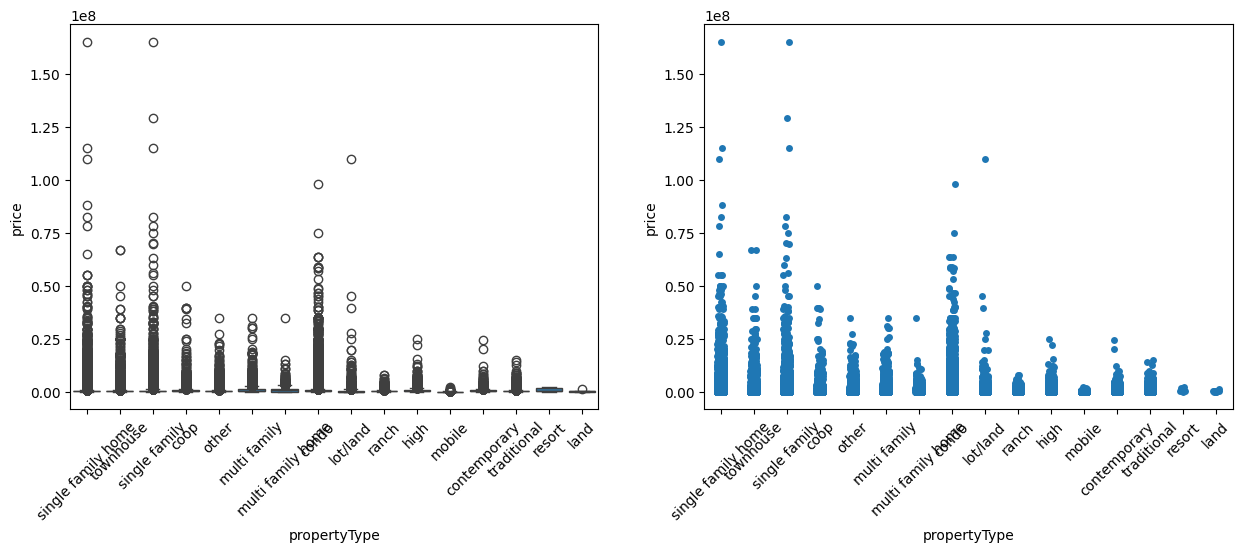

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=axes[0], x='propertyType', y='price', data=df)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

sns.stripplot(ax=axes[1], x='propertyType', y='price', data=df)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

plt.show()

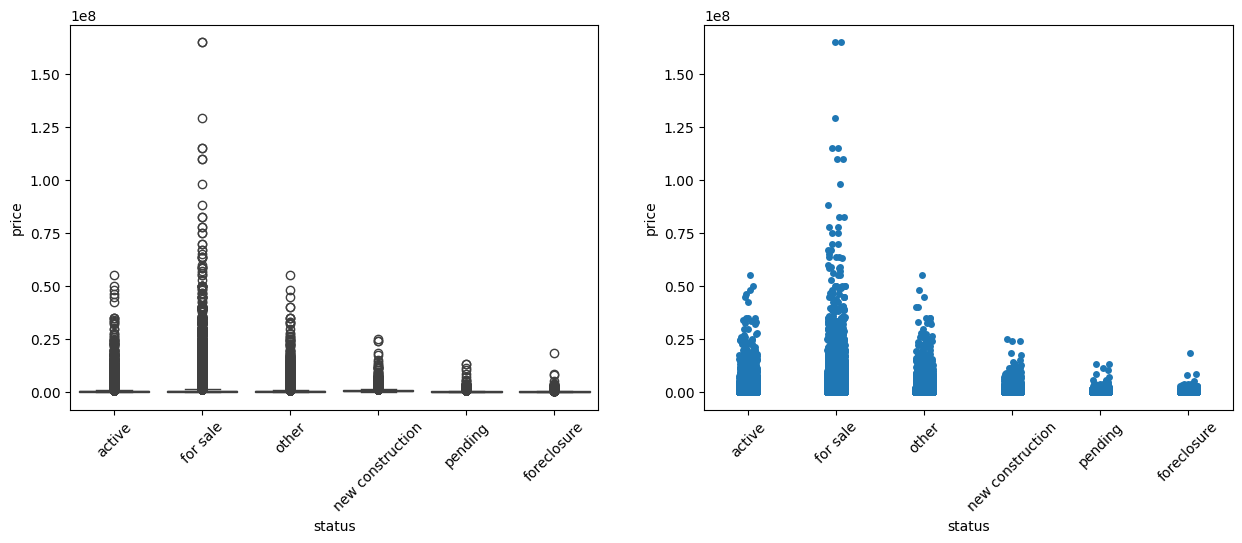

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=axes[0], x='status', y='price', data=df)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

sns.stripplot(ax=axes[1], x='status', y='price', data=df)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

plt.show()

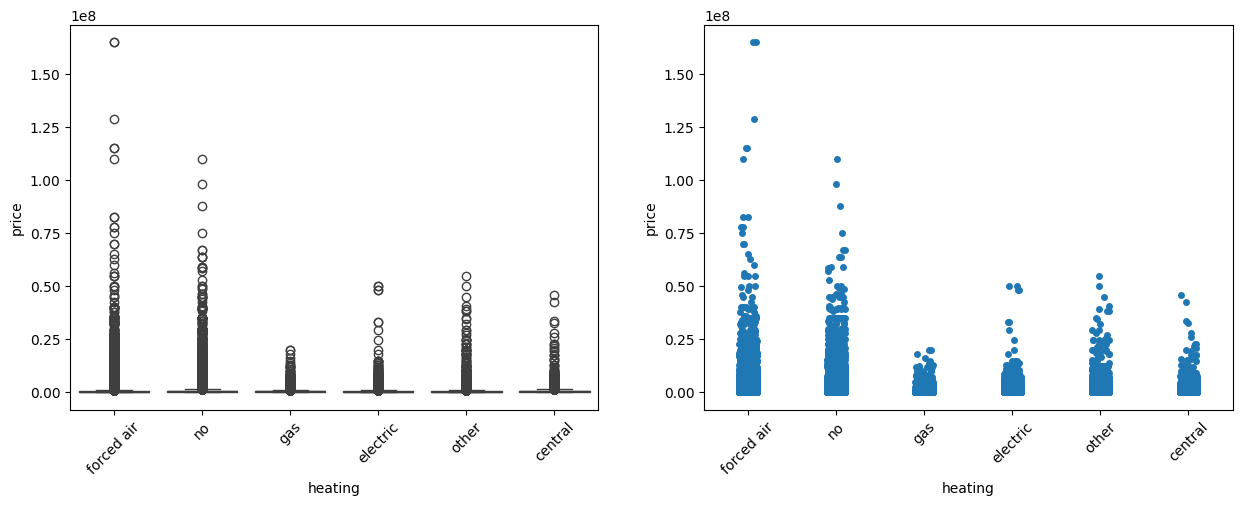

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=axes[0], x='heating', y='price', data=df)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

sns.stripplot(ax=axes[1], x='heating', y='price', data=df)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

plt.show()

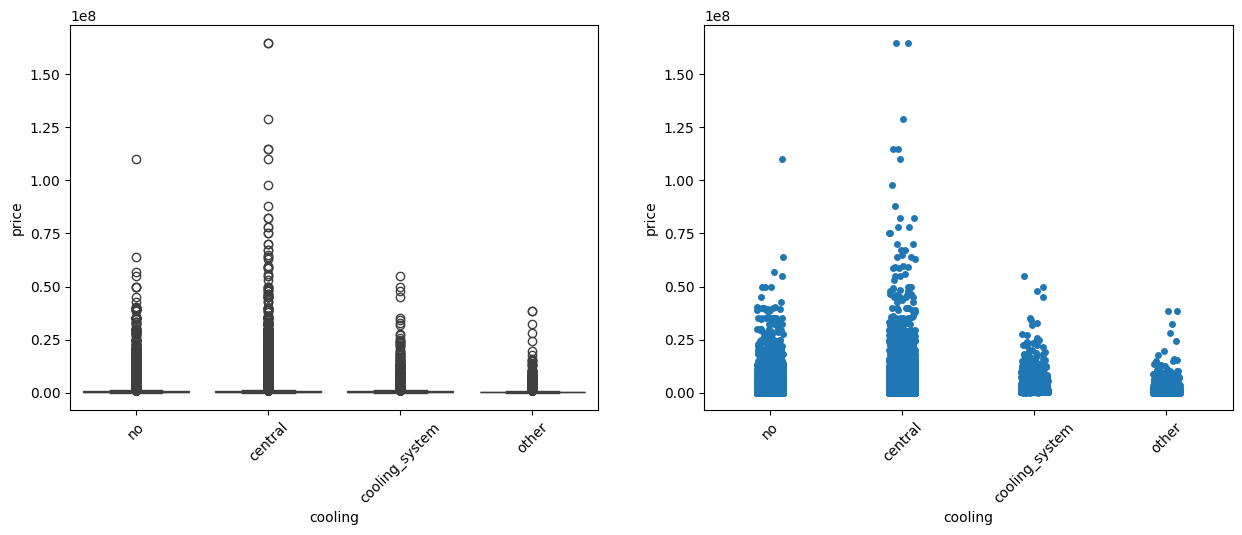

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(ax=axes[0], x='cooling', y='price', data=df)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

sns.stripplot(ax=axes[1], x='cooling', y='price', data=df)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)  # Названия под углом 45 градусов

plt.show()

In [217]:
fig = px.bar(
    data_frame= df.groupby(['status'], as_index=False)['price'].mean(),
    x='status',
    y='price',
    color='status',
    text='price', 
    orientation='v',
    title='Median value of the price from the status',
    height=500, 
    width=1000   
)

fig.show()

In [218]:
fig = px.bar(
    data_frame= df.groupby(['propertyType'], as_index=False)['price'].mean(),
    x='propertyType',
    y='price',
    color='propertyType',
    text='price', 
    orientation='v',
    title='Median value of the price from the propertyType',
    height=500, 
    width=1000   
)

fig.show()

Взглянем на карту, как расположились наши объекты. Посмотреть можно файл 'heatmap.html'

In [22]:
# Создание базовой карты
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)  # Центрируем карту на центральных координатах США и устанавливаем масштаб

# Преобразование данных о недвижимости в формат, подходящий для построения тепловой карты
heat_data = [[row['lat'], row['lng'], row['price']] for index, row in df.iterrows()]

# Добавляем тепловую карту на базовую
HeatMap(heat_data, radius=15).add_to(m)

# Сохранение карты в HTML файл
m.save('heatmap.html')

И так, заметим, видно - что часть объектов находится за пределами США. Поэтому мы их найдем и удалим

А пока - статус прочие переименуем в актив, т.к. средняя цена у них близка между собой

In [28]:
# Замена значений в столбце 'status'
df['status'] = df['status'].replace(['other'], 'active')
df.status.unique()

array(['active', 'for sale', 'new construction', 'pending', 'foreclosure',
       'rent'], dtype=object)

Такой же фокус проделываем и с типом недвижимости

In [29]:
df['propertyType'] = df['propertyType'].replace(['contemporary'], 'single family')
df['propertyType'] = df['propertyType'].replace(['other',], 'single family home')
df.propertyType.unique()

array(['single family home', 'townhouse', 'single family', 'coop',
       'multi family', 'multi family home', 'condo', 'lot/land', 'ranch',
       'high', 'mobile', 'traditional', 'resort', 'land'], dtype=object)

Скопируем наш датафрейм, чтобы не проделывать вышеприведенные процедуры

In [119]:
dfx = df.copy()

Предпочту удалить пустые значения в геоточках, конечно это много 90тыс - но лучше качественней набор, чем абы какой. Конечно, можно углубиться в адреса - но нам за это пока не платят, поэтому делаем как есть. Тем более, модель можно и дообучить в будущем.

In [120]:
# Удаление строк с пустыми значениями в столбцах 'lat' и 'lng'
dfx.dropna(subset=['lat', 'lng'], inplace=True)
# Сброс индексов после удаления строк
dfx.reset_index(drop=True, inplace=True)

In [121]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226491 entries, 0 to 226490
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                226491 non-null  object 
 1   propertyType          226491 non-null  object 
 2   baths                 226491 non-null  float64
 3   city                  226491 non-null  object 
 4   sqft                  226491 non-null  int64  
 5   zipcode               226491 non-null  int64  
 6   beds                  226491 non-null  int32  
 7   state                 226491 non-null  object 
 8   stories               226491 non-null  int32  
 9   year_built            226491 non-null  float64
 10  remodeled             226491 non-null  int64  
 11  heating               226491 non-null  object 
 12  cooling               226491 non-null  object 
 13  parking               226491 non-null  object 
 14  lotsize               226491 non-null  int64  
 15  

Так как нижеуказанные признаки носят в ценовом диапозоне разношерстный характер - то приведем их к бинару.

In [122]:
dfx['parking'] = dfx['parking'].apply(lambda x: 'no' if x == 'no' else 'yes')
dfx['cooling'] = dfx['cooling'].apply(lambda x: 'no' if x == 'no' else 'yes')
dfx['heating'] = dfx['heating'].apply(lambda x: 'no' if x == 'no' else 'yes')
dfx['remodeled'] = dfx['remodeled'].apply(lambda x: 'no' if x == 0 else 'yes')

избавимся от выбросов в геоточках

In [123]:
# Определим границы США
min_lat_usa, max_lat_usa = 24.396308, 49.384358
min_lng_usa, max_lng_usa = -125.000000, -66.93457

# Найдем координаты, которые выходят за пределы США
out_of_usa = dfx[(dfx['lat'] < min_lat_usa) | (dfx['lat'] > max_lat_usa) | (dfx['lng'] < min_lng_usa) | (dfx['lng'] > max_lng_usa)]

# Выведем найденные координаты
print("Координаты за пределами США:")
print(out_of_usa)

Координаты за пределами США:
                  status        propertyType  baths          city  sqft  \
1392              active           townhouse    3.0  jacksonville  1725   
6551             pending  single family home    4.0     cleveland  3023   
8237            for sale               condo    1.0       detroit  1200   
11648           for sale               condo    2.0     san pedro  1443   
12156             active  single family home    3.0     charlotte  2026   
21320           for sale           townhouse    3.0     san pedro  1576   
24173           for sale  single family home    2.0     san pedro   951   
30980           for sale              mobile    2.0     san pedro  1880   
34115           for sale           townhouse    2.0     charlotte  1802   
37763           for sale           townhouse    4.0     charlotte  2026   
41198           for sale           townhouse    3.0     charlotte  2382   
48031           for sale              mobile    2.0     san pedro  1700

Как оказалось их всего 39 объектов

In [124]:
# Фильтрация и удаление строк, которые находятся за пределами США
dfx = dfx[(dfx['lat'] >= min_lat_usa) & (dfx['lat'] <= max_lat_usa) & (dfx['lng'] >= min_lng_usa) & (dfx['lng'] <= max_lng_usa)]
# Сброс индекса после удаления строк
dfx = dfx.reset_index(drop=True)

Создадим новый признак - хоумсистем, объединим уже два бинарных признакак охлаждение и отопление

In [125]:
# Создание нового признака 'home_system' путем суммирования 'cooling' и 'heating'
dfx['home_system'] = dfx['cooling'] + dfx['heating']

In [114]:
dfx.home_system.value_counts()

home_system
yesyes    157887
nono       31882
noyes      23122
yesno      13561
Name: count, dtype: int64

Урежем наши данные по штатам - оставим только самые важные, остальные назовем - прочие ("OTR")

In [126]:
# Список значений, которые оставляем без изменений
keep_values = ["FL", "CA", "NY", "WA"]

# Заменяем все остальные значения на "OTHER"
dfx['state'] = dfx['state'].apply(lambda x: x if x in keep_values else "OTR")

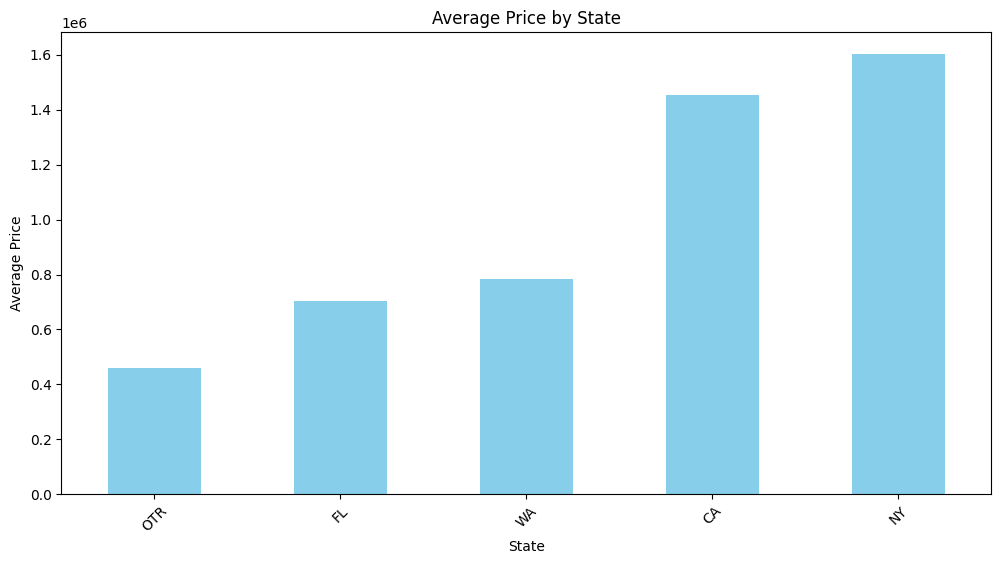

In [127]:
# Группировка данных по штатам и вычисление средней цены
average_price_by_state = dfx.groupby('state')['price'].mean().sort_values()

# Создание графика
plt.figure(figsize=(12, 6))
average_price_by_state.plot(kind='bar', color='skyblue')
plt.title('Average Price by State')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

Закодируем для нас важные признаки, остальные пустим через LabelEncoder

In [128]:
# Создание словаря для кодирования признака state
state_map = {
    'NY': 5,
    'CA': 4,
    'WA': 3,
    'FL': 2,
    'OTR': 1
}

# Применение кодировщика с использованием map
dfx['state'] = dfx['state'].map(state_map)

In [129]:
# Создание словаря для кодирования признака home_system
system_map = {
    'yesyes': 2,
    'nono': 0,
    'noyes': 1,
    'yesno': 1
}

# Применение кодировщика с использованием map
dfx['home_system'] = dfx['home_system'].map(system_map)

Проделаем тоже самое с признаком статус

In [130]:
# Создание словаря для кодирования признака status
status_map = {
    'for sale': 5,
    'new construction': 6,
    'active': 4,
    'pending': 3,
    'foreclosure': 2,
    'rent': 1
}

# Применение кодировщика с использованием map
dfx['status'] = dfx['status'].map(status_map)

Повторимся с типом недвижимости

In [131]:
# Создание словаря для кодирования признака propertyType
propertyType_map = {
    'single family home': 6,
    'townhouse': 7,
    'single family': 8,
    'multi family': 11,
    'condo': 9,
    'land': 2,
    'ranch': 3,
    'mobile': 1,
    'traditional': 4,
    'lot/land': 5,
    'resort': 14,
    'multi family home': 13,
    'coop': 12,
    'high': 10
}

# Применение кодировщика с использованием map
dfx['propertyType'] = dfx['propertyType'].map(propertyType_map)

Остальные признаки пустим через LabelEncoder

In [132]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Проход по всем столбцам DataFrame и кодирование признаков типа 'object'
for column in dfx.columns:
    if dfx[column].dtype == 'object':
        dfx[column] = label_encoder.fit_transform(dfx[column])

Взглянем на общую картину нашего датафрейма

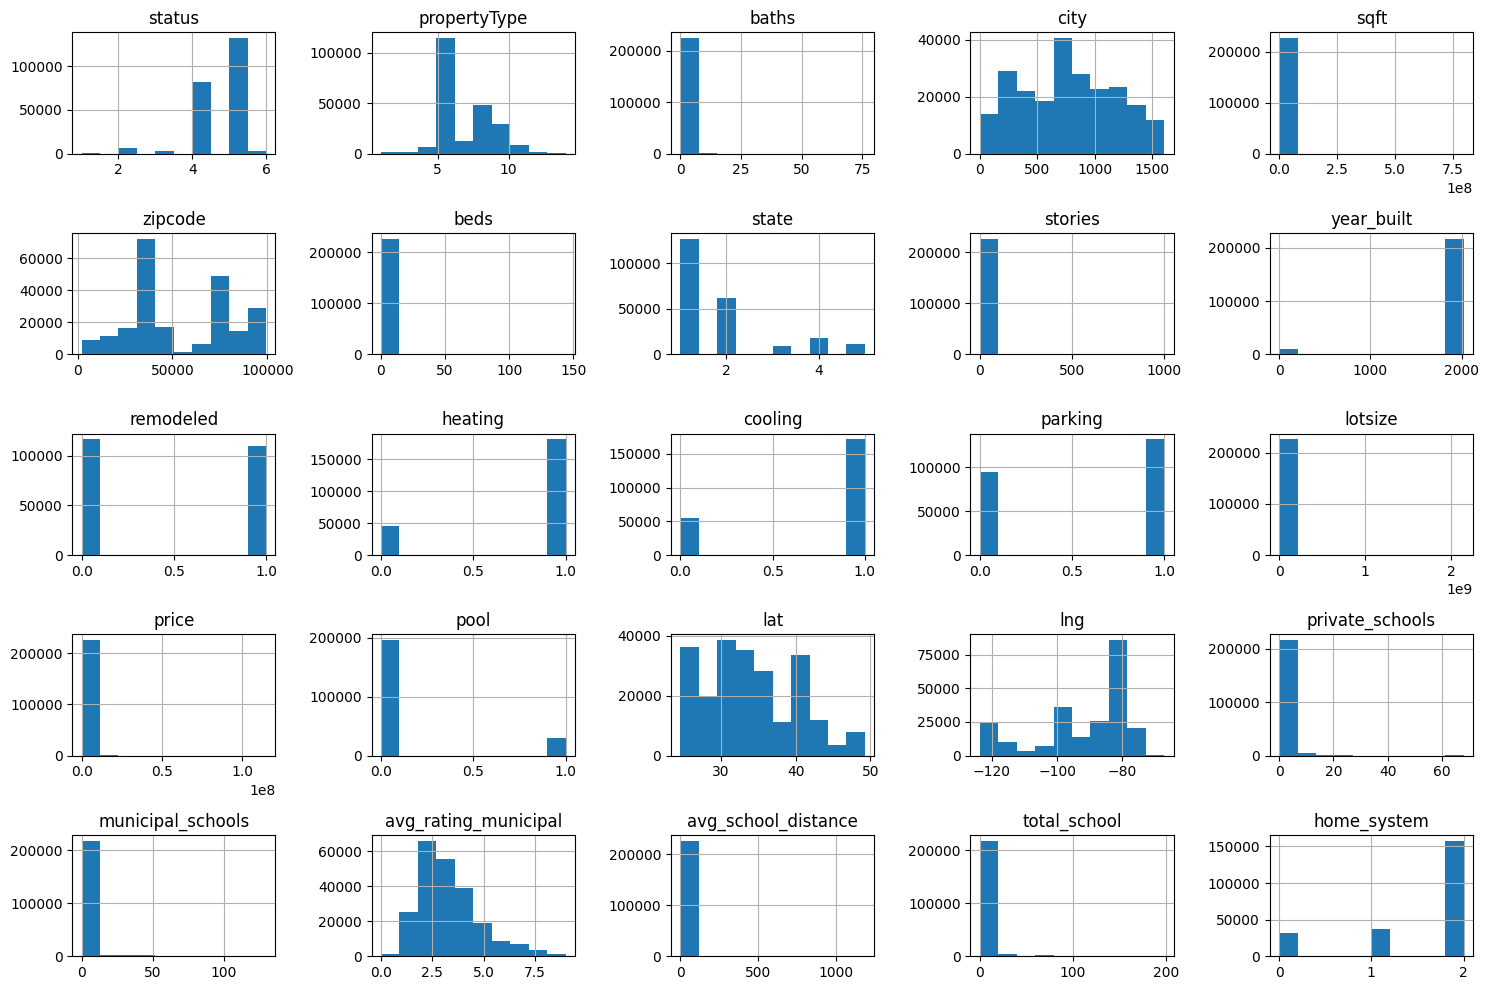

In [133]:
# Создание гистограмм для каждого столбца в DataFrame
dfx.hist(figsize=(15, 10))
plt.tight_layout()

Посмотрим как признаки соотносятся между собой

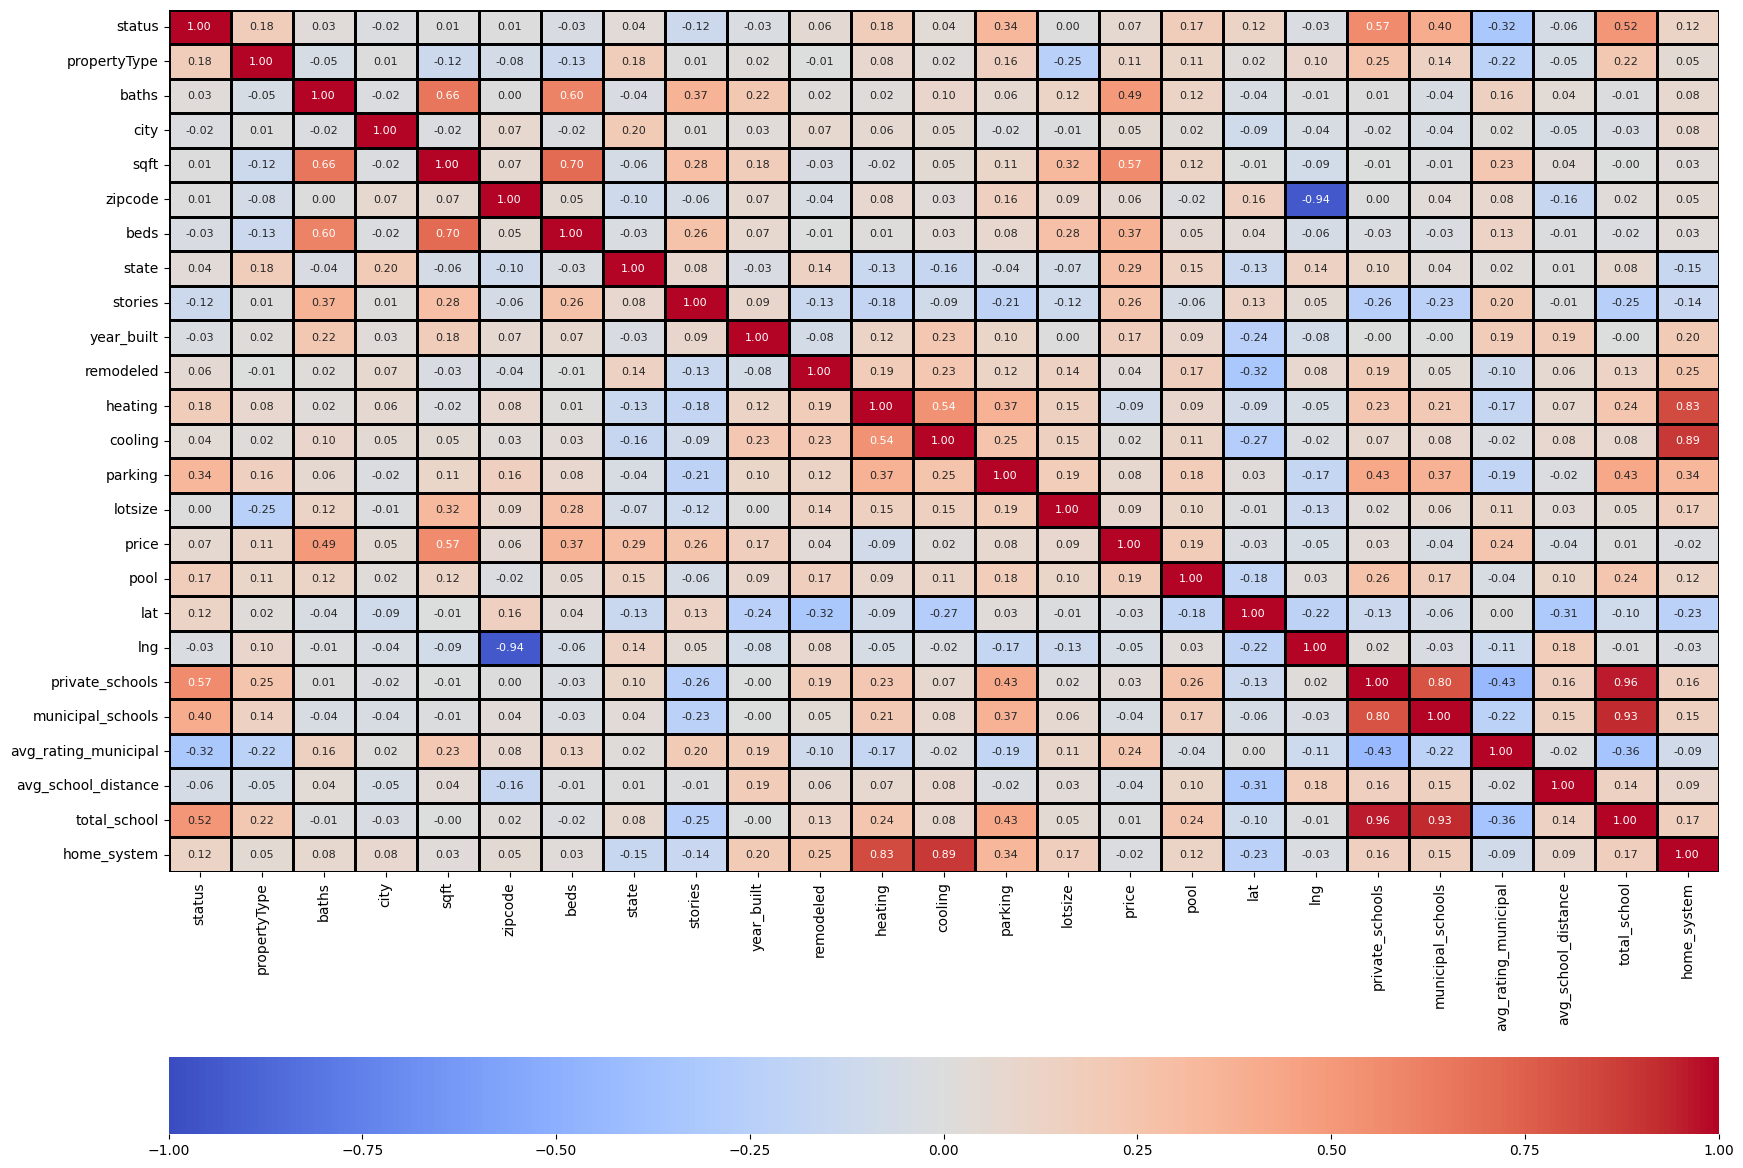

In [134]:
#Строим тепловую карту данных, чтобы посмотреть на взаимосвязь признаков
fig, ax = plt.subplots(figsize=(20, 16))
heatmap = sns.heatmap(dfx.corr(method='spearman'), annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
for text in ax.texts:
    text.set_fontsize(8)  # Установка размера шрифта
plt.show()

Перед удалением коррелирующих между собой признаков - посмотрим как наши данные распределены, а потом сделаем выбор по тесту

In [39]:
# Проверка нормальности распределения
p_value = stats.shapiro(dfx)[1]
if p_value > 0.05:
    print("Данные распределены нормально")
else:
    print("Данные не распределены нормально")

Данные не распределены нормально


Как и ожидалось - данные распределены ненормально, поэтому будем использовать тест ANOVA

In [299]:
# Создаем модель ANOVA
model = ols('price ~ C(avg_rating_municipal)', data=dfx).fit()

# Проводим анализ дисперсии (ANOVA)
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(avg_rating_municipal),42041.192610,242.0,178.35629,0.0
Residual,220333.793299,226209.0,NaN,NaN


Средний рейтинг весьма влияет на стоимость - поэтому мы его оставим

In [300]:
# Создаем модель ANOVA
model = ols('price ~ C(remodeled)', data=dfx).fit()

# Проводим анализ дисперсии (ANOVA)
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(remodeled),1132.793816,1.0,981.928522,4.408426e-215
Residual,261242.192093,226450.0,NaN,NaN


Перестройка влияет, но не так, как рейтинг школы - можно его конечно удалить, но оставим для проформы, все равно отвалится

Пока удалим коррелирующие признаки между собой

In [135]:
dfx.drop(columns=['baths','beds','municipal_schools','private_schools','cooling','heating','zipcode'], inplace=True)

Уменьшим по максиму размер оставшегося датафрейма

In [136]:
dfx.apply((pd.to_numeric),downcast = 'signed')

,status,propertyType,city,sqft,state,stories,year_built,remodeled,parking,lotsize,price,pool,lat,lng,avg_rating_municipal,avg_school_distance,total_school,home_system
0,4,6,1349,2900,1,4,2019,0,0,0,418000,0,35.174047,-79.392254,5.20,5.54,5,1
1,5,6,1359,1947,3,2,2019,0,0,5828,310000,0,47.699473,-117.231266,2.20,1.33,8,0
2,5,6,825,3000,4,1,1961,1,1,8626,2895000,1,34.071403,-118.500654,3.83,1.96,9,2
3,5,6,346,6457,1,3,2006,1,1,8220,2395000,0,32.834849,-96.807426,4.00,0.75,13,2
4,5,7,1094,897,1,2,1920,0,0,680,209000,0,39.932969,-75.192063,0.00,2.78,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226447,4,8,1050,1829,2,1,1962,1,1,7704,171306,0,28.536635,-81.417645,1.67,1.30,9,2
226448,4,4,499,1895,1,3,1921,0,0,7500,199900,0,32.711046,-97.330033,5.00,1.27,3,1
226449,4,8,891,4017,2,4,1990,1,1,8500,1249000,1,25.967980,-80.156065,2.00,16.60,7,2
226450,5,9,257,2000,1,2,1924,0,0,0,674999,0,41.976584,-87.650232,2.67,4.14,9,1


Прологарифмируем наш таргет

In [137]:
dfx['price'] = np.log(dfx['price']+1)

In [138]:
y = dfx['price']
X = dfx.drop(columns='price')

Так как наш датафрейм полон выбросов - сначала произведем квантильное трансформирование, а затем стандартизируем

In [139]:
# Создаем пайплайн
pipeline = Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('standard_scaler', StandardScaler())
])

# Применяем пайплайн к данным
X_pip = pipeline.fit_transform(X)

Произведем стандартную разбивку на тренировочный и тестовый наборы

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_pip, y, test_size=0.2, random_state=42)

Убедимся, что все ОК)

In [141]:
# Проверка предварительной обработки данных
# Убедимся, что данные не содержат отсутствующих значений
print("Отсутствующие значения в X_train:", np.isnan(X_train).any())
print("Отсутствующие значения в X_test:", np.isnan(X_test).any())

#  Убедимся, что данные нормализованы или масштабированы
print("Среднее значение X_train:", np.mean(X_train))
print("Среднее значение X_test:", np.mean(X_test))
print("Стандартное отклонение X_train:", np.std(X_train))
print("Стандартное отклонение X_test:", np.std(X_test))

# Проверим размерность данных после предварительной обработки
print("Размерность X_train после предварительной обработки:", X_train.shape)
print("Размерность X_test после предварительной обработки:", X_test.shape)

Отсутствующие значения в X_train: False
Отсутствующие значения в X_test: False
Среднее значение X_train: -0.00010851303661570812
Среднее значение X_test: 0.00043404495874108014
Стандартное отклонение X_train: 0.9999921206829693
Стандартное отклонение X_test: 1.000031398381833
Размерность X_train после предварительной обработки: (181161, 17)
Размерность X_test после предварительной обработки: (45291, 17)


Все выглядит прилично и безобидно

По всей вероятности классические линейные модели не переварят эти данные(датфарейм полон выбросов - а они очень чувствительны к ним), лучше всего проглотят их более сложные ансамбли - но мы удостоверимся в нашей правоте и напишем функцию с наиболее вероятными сценариями

In [143]:
def AIC_score(y_true, y_pred, df):
    """
    Calculate the Akaike Information Criterion (AIC) value.

    Args:
        y_true (array-like): Observed values of the target variable
        y_pred (array-like): Predicted values of the target variable
        df (int): Degrees of freedom in the model

    Returns:
        float: AIC value
    """
    residuals = y_true - y_pred
    RSS = np.sum(residuals**2)
    AIC = len(y_true) * np.log(RSS/len(y_true)) + 2 * df

    return AIC

def regression_models_with_metrics(X, y):
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(),
        "Bayesian Ridge": BayesianRidge(),
        "Lasso Lars IC": LassoLarsIC(),
        "Decision Tree": DecisionTreeRegressor(),
        "Random Forest": RandomForestRegressor(),
        "XGBRegressor": XGBRegressor(),
        "Gradient Boosting": GradientBoostingRegressor(),
        "CatBoost": CatBoostRegressor()
    }

    for name, model in models.items():
        start_time = time.time()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        aic = AIC_score(y_test, y_pred, X.shape[1])
        end_time = time.time()
        print(f"Model: {name}")
        print("Mean Squared Error (MSE):", mse)
        print("R-squared (R2) Score:", r2)
        print("Akaike Information Criterion (AIC):", aic)
        print(f"Time: {end_time - start_time} seconds")
        print("-------------------------")

In [144]:
regression_models_with_metrics(X_pip, y)

Model: Linear Regression
Mean Squared Error (MSE): 0.6313669215068575
R-squared (R2) Score: 0.45174227667013933
Akaike Information Criterion (AIC): -20793.88581614122
Time: 0.18831753730773926 seconds
-------------------------
Model: Ridge Regression
Mean Squared Error (MSE): 0.6313668906952528
R-squared (R2) Score: 0.45174230342589683
Akaike Information Criterion (AIC): -20793.88802640656
Time: 0.10391783714294434 seconds
-------------------------
Model: Bayesian Ridge
Mean Squared Error (MSE): 0.6313662721257262
R-squared (R2) Score: 0.4517428405707944
Akaike Information Criterion (AIC): -20793.93239941149
Time: 0.2894890308380127 seconds
-------------------------
Model: Lasso Lars IC
Mean Squared Error (MSE): 0.6313669215068575
R-squared (R2) Score: 0.45174227667013933
Akaike Information Criterion (AIC): -20793.88581614122
Time: 0.2635159492492676 seconds
-------------------------
Model: Decision Tree
Mean Squared Error (MSE): 0.2523889688120913
R-squared (R2) Score: 0.7808339386798

Как и говорил ранее - ансамбли наиболее подходящте модели для данного набора данных, выделим только три из них: RandomForestRegressor, XGBRegressor и CatBoostRegressor. Обучим сначала их на всем наборе - потом посмотрим на урезанном. Соотвественно подберем гиперпараметры посредством Optuna. За основу метрики возьмем среднеквадратичную ошибку MSE и R2 Score, чтобы посмотреть насколько набор данных у нас охвачен моделями. Вывод будет сделан уже при сравнении всех трех моделей.

In [ ]:
def optuna_catboost(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 0.1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-9, 10)
    }
    
    # Create and train the model with the selected parameters
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train)
    
    # Calculate and return the score
    score = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    return score

# Create an Optuna study for CatBoostRegressor
catboost_study = optuna.create_study(study_name="CatBoostRegressor", direction="minimize")
catboost_study.optimize(optuna_catboost, n_trials=25)

# Output the best hyperparameters for CatBoostRegressor
print("Best hyperparameters for CatBoostRegressor: {}".format(catboost_study.best_params))

Best hyperparameters for CatBoostRegressor: {'n_estimators': 1859, 'depth': 7, 'learning_rate': 0.09404196700962725, 'l2_leaf_reg': 4.954594965465358e-06, 'random_strength': 9.837040747699056}

In [145]:
#  Создание и обучение модели CatBoostRegressor
CatBoostReg_model = CatBoostRegressor(n_estimators=1859, depth=7, learning_rate=0.09404196700962725, l2_leaf_reg=4.954594965465358e-06, random_strength=9.837040747699056)
CatBoostReg_model.fit(X_train, y_train)
CatBoostReg_pred = CatBoostReg_model.predict(X_test)
print('MSE score: {:.3f}'.format(metrics.mean_squared_error(y_test, CatBoostReg_pred)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, CatBoostReg_pred)))

0:	learn: 1.0295664	total: 31.3ms	remaining: 58.1s
1:	learn: 0.9865620	total: 51.5ms	remaining: 47.8s
2:	learn: 0.9492567	total: 71.3ms	remaining: 44.1s
3:	learn: 0.9139891	total: 90.9ms	remaining: 42.2s
4:	learn: 0.8863796	total: 110ms	remaining: 40.8s
5:	learn: 0.8596880	total: 128ms	remaining: 39.6s
6:	learn: 0.8326480	total: 150ms	remaining: 39.6s
7:	learn: 0.8128427	total: 172ms	remaining: 39.9s
8:	learn: 0.7938119	total: 193ms	remaining: 39.6s
9:	learn: 0.7743570	total: 211ms	remaining: 39s
10:	learn: 0.7575919	total: 229ms	remaining: 38.5s
11:	learn: 0.7446868	total: 249ms	remaining: 38.3s
12:	learn: 0.7333329	total: 268ms	remaining: 38.1s
13:	learn: 0.7224201	total: 291ms	remaining: 38.3s
14:	learn: 0.7126175	total: 313ms	remaining: 38.5s
15:	learn: 0.7019644	total: 333ms	remaining: 38.3s
16:	learn: 0.6926226	total: 354ms	remaining: 38.3s
17:	learn: 0.6843237	total: 374ms	remaining: 38.3s
18:	learn: 0.6762539	total: 395ms	remaining: 38.2s
19:	learn: 0.6700711	total: 415ms	remai

In [82]:
# Проведение кросс-валидации
cbr_cv_scores = cross_val_score(CatBoostReg_model, X_pip, y, cv=5, scoring='neg_mean_squared_error')

# Вывод среднего значения оценки MSE
print("Среднее значение MSE по кросс-валидации:", -cbr_cv_scores.mean())

0:	learn: 1.0292810	total: 28.4ms	remaining: 52.8s
1:	learn: 0.9881596	total: 51.8ms	remaining: 48.1s
2:	learn: 0.9525157	total: 76.3ms	remaining: 47.2s
3:	learn: 0.9225713	total: 98.2ms	remaining: 45.5s
4:	learn: 0.8937175	total: 123ms	remaining: 45.5s
5:	learn: 0.8687149	total: 146ms	remaining: 45s
6:	learn: 0.8456861	total: 169ms	remaining: 44.8s
7:	learn: 0.8252536	total: 192ms	remaining: 44.4s
8:	learn: 0.8055116	total: 214ms	remaining: 44s
9:	learn: 0.7858893	total: 234ms	remaining: 43.2s
10:	learn: 0.7670736	total: 256ms	remaining: 43s
11:	learn: 0.7491638	total: 282ms	remaining: 43.4s
12:	learn: 0.7368633	total: 308ms	remaining: 43.8s
13:	learn: 0.7265498	total: 331ms	remaining: 43.7s
14:	learn: 0.7174509	total: 359ms	remaining: 44.2s
15:	learn: 0.7064785	total: 383ms	remaining: 44.1s
16:	learn: 0.6967166	total: 408ms	remaining: 44.2s
17:	learn: 0.6877777	total: 431ms	remaining: 44.1s
18:	learn: 0.6787977	total: 455ms	remaining: 44.1s
19:	learn: 0.6719845	total: 479ms	remaining

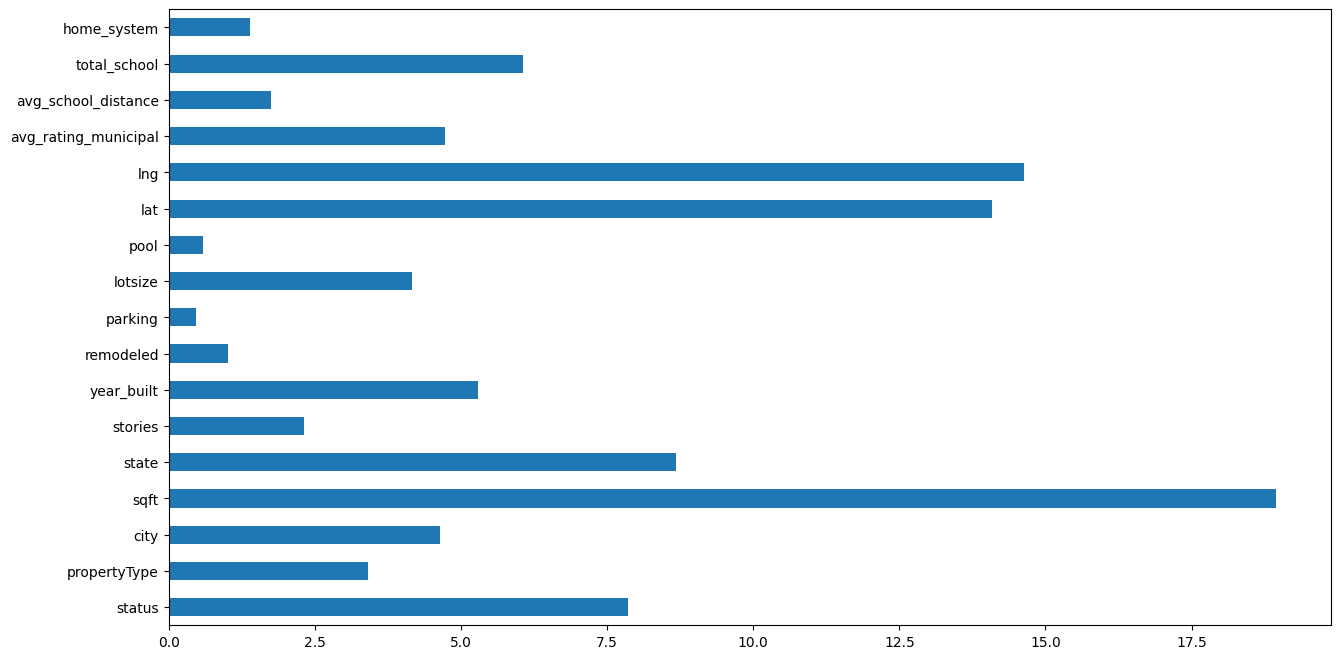

In [146]:
# выводим признаки по важности для модели
plt.rcParams['figure.figsize'] = (15, 8)
feat_importances = pd.Series(CatBoostReg_model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh');

In [ ]:
def optuna_gb(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    
    # Calculate and return the accuracy score
    score = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    return score

# Create an Optuna study for XGBRegressor
XGB_study = optuna.create_study(study_name="XGB", direction="minimize")
XGB_study.optimize(optuna_gb, n_trials=25)

# Output the best hyperparameters for XGBRegressor
print("Best hyperparameters for XGBRegressor: {}".format(XGB_study.best_params))

Best hyperparameters for XGBRegressor: {'n_estimators': 1669, 'max_depth': 11, 'learning_rate': 0.04538729233629271, 'subsample': 0.7656750596233441, 'colsample_bytree': 0.7325912650804138, 'reg_alpha': 7.189800516605014e-06, 'reg_lambda': 1.6272972337974908e-08}

In [147]:
# Создание и обучение модели XGBRegressor
XGBRegressor_model = XGBRegressor(n_estimators= 1669, max_depth= 11, learning_rate= 0.04538729233629271, subsample= 0.7656750596233441, colsample_bytree= 0.7325912650804138, reg_alpha= 7.189800516605014e-06, reg_lambda= 1.6272972337974908e-08)
XGBRegressor_model.fit(X_train, y_train)
XGBRegressor_pred = XGBRegressor_model.predict(X_test)
print('MSE score: {:.3f}'.format(metrics.mean_squared_error(y_test, XGBRegressor_pred)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, XGBRegressor_pred)))

MSE score: 0.096
R2 score: 0.916


In [45]:
# Проведение кросс-валидации
XGBRegressor_cv_scores = cross_val_score(XGBRegressor_model, X_pip, y, cv=5, scoring='neg_mean_squared_error')

# Вывод среднего значения оценки MSE
print("Среднее значение MSE по кросс-валидации:", -XGBRegressor_cv_scores.mean())

Среднее значение MSE по кросс-валидации: 0.09397990471350456


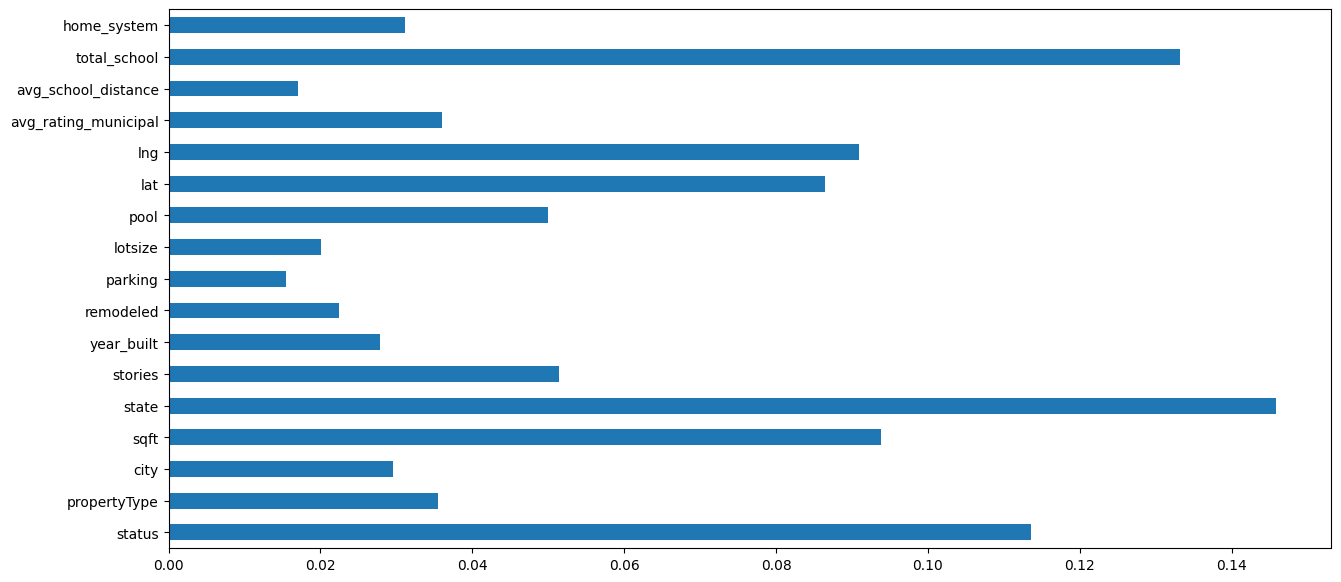

In [53]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15, 7)
feat_importances = pd.Series(XGBRegressor_model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

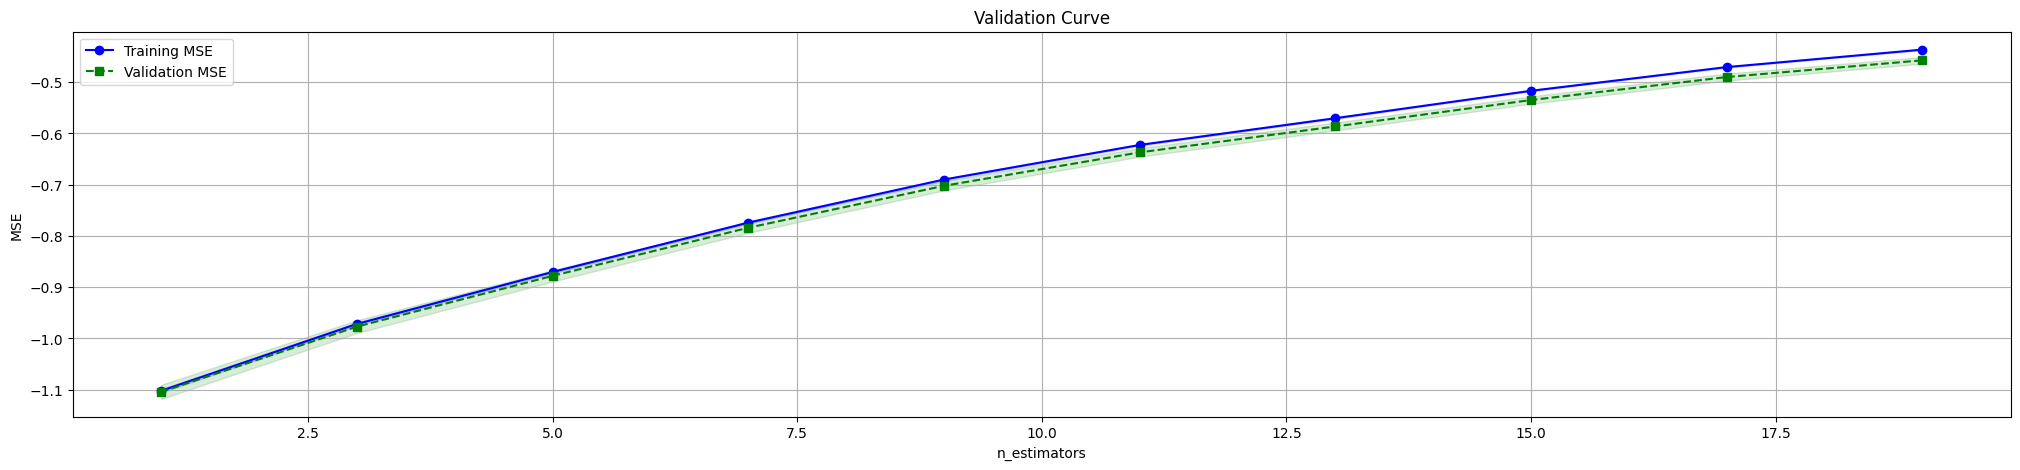

In [69]:
from sklearn.model_selection import validation_curve

# Определение диапазона значений гиперпараметра, который мы хотим исследовать
param_range = np.arange(1, 20, 2)

# Построение валидационной кривой для гиперпараметра 'n_estimators'
train_scores, test_scores = validation_curve(
    XGBRegressor(**XGB_study.best_params), X_pip, y, param_name='n_estimators', param_range=param_range,
    scoring='neg_mean_squared_error', cv=5)

# Вычисление средних значений и стандартных отклонений для обучающей и тестовой выборок
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Построение кривой
plt.figure(figsize=(25, 5))
plt.plot(param_range, train_mean, color='blue', marker='o', label='Training MSE')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', label='Validation MSE')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Validation Curve')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [ ]:
def optuna_randomforest(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }
    
    # Create and train the model with the selected parameters
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    
    # Calculate and return the score
    score = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    return score

# Create an Optuna study for RandomForestRegressor
randomforest_study = optuna.create_study(study_name="RandomForestRegressor", direction="minimize")
randomforest_study.optimize(optuna_randomforest, n_trials=25)

# Output the best hyperparameters for RandomForestRegressor
print("Best hyperparameters for RandomForestRegressor: {}".format(randomforest_study.best_params))

Best hyperparameters for RandomForestRegressor: {'n_estimators': 1354, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 3}

In [148]:
# Создание и обучение модели RandomForestRegressor
RandomForestReg_model = RandomForestRegressor(n_estimators= 1354, max_depth= 20, min_samples_split= 9, min_samples_leaf= 3)
RandomForestReg_model.fit(X_train, y_train)
RandomForestReg_pred = RandomForestReg_model.predict(X_test)

print('MSE score: {:.3f}'.format(metrics.mean_squared_error(y_test, RandomForestReg_pred)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test, RandomForestReg_pred)))

MSE score: 0.142
R2 score: 0.877


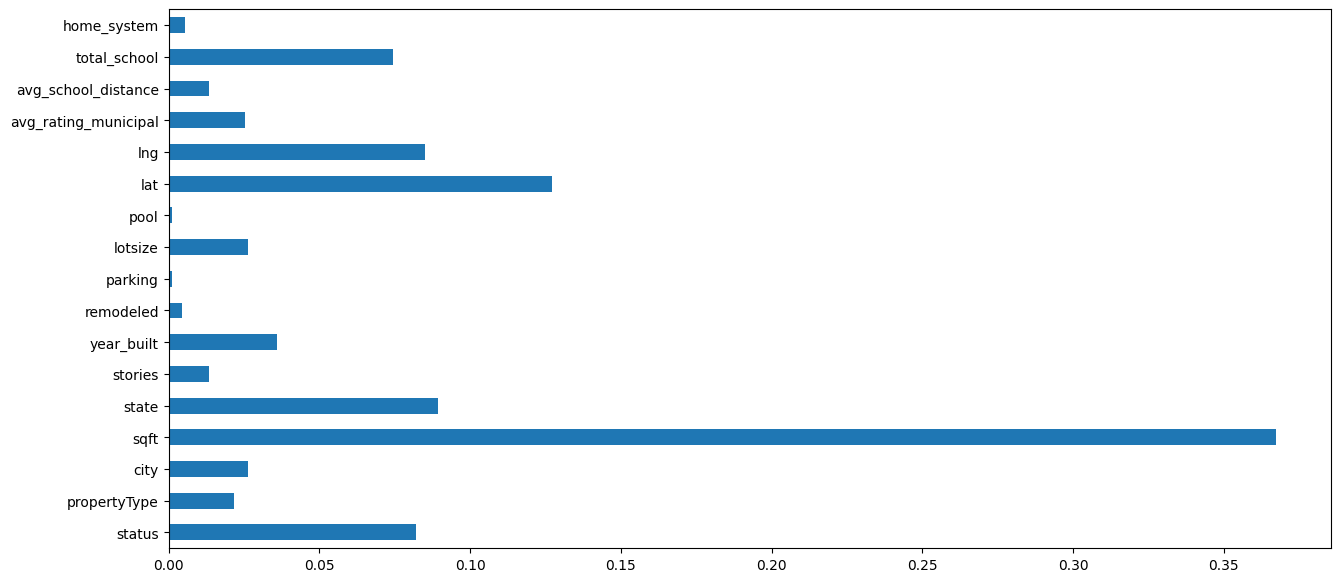

In [149]:
# выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (15, 7)
feat_importances = pd.Series(RandomForestReg_model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

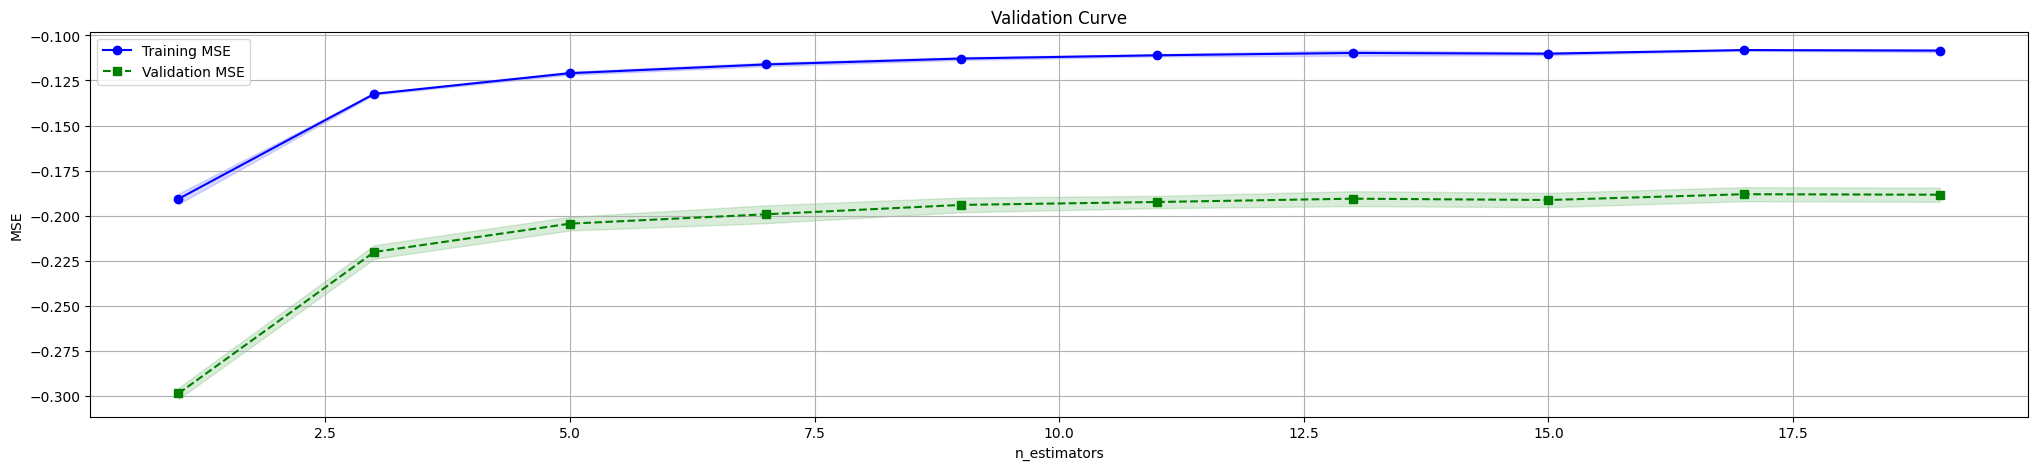

In [76]:
from sklearn.model_selection import validation_curve

# Определение диапазона значений гиперпараметра, который мы хотим исследовать
param_range = np.arange(1, 20, 2)

# Построение валидационной кривой для гиперпараметра 'n_estimators'
train_scores, test_scores = validation_curve(
    RandomForestRegressor(**randomforest_study.best_params), X_pip, y, param_name='n_estimators', param_range=param_range,
    scoring='neg_mean_squared_error', cv=5)

# Вычисление средних значений и стандартных отклонений для обучающей и тестовой выборок
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Построение кривой
plt.figure(figsize=(25, 5))
plt.plot(param_range, train_mean, color='blue', marker='o', label='Training MSE')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', label='Validation MSE')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Validation Curve')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.legend(loc='upper left')
plt.grid()
plt.show()

**Выводы:**

Как видно из показателей, так и исходя из кроссвалидации первой и третьей модели - они не отвечают нашим требованиям. Это RandomForestRegressor MSE score: 0.143
R2 score: 0.876 - мало того, что показатель самые низкие из трех моделей - так и кроссвалидация показывает нам, что модели не хватает данных; CatBoostRegressor MSE score: 0.119 R2 score: 0.897. - показатели выше чем, у RandomForestRegressor - но по графику кроссвалидации видно, что модель переобучилась на данных - что нас не устраивает совсем.
XGBRegressor - лидер, как по показателям MSE score: 0.096  R2 score: 0.916, так и по кроссвалидации -заметно, что графики не совпадают, как у CatBoostRegressor - и не находятся далеко друг от друга, как у RandomForestRegressor.

За основу берем модель XGBRegressor, но для своего спокойствия - проведем бутстрэп-валидацию, метод оценки качества модели, который основан на повторном выборе образцов из исходного набора данных с возвращением. Бутстрэп-валидация позволяет оценить устойчивость и обобщающую способность модели путем проведения множества случайных выборок из исходного набора данных. Очень полезный метод к данным, в которых очень много выбросов.

In [86]:
from sklearn.utils import resample

# Количество итераций бутстрэпа
n_iterations = 10

# Количество фолдов в перекрестной проверке
n_folds = 5

# Список для хранения оценок производительности модели
scores = []

for _ in range(n_iterations):
    # Создание бутстрэп-выборки
    X_bootstrap, y_bootstrap = resample(X_pip, y)

    # Перекрестная проверка модели
    cv_scores = cross_val_score(XGBRegressor_model, X_bootstrap, y_bootstrap, cv=n_folds)

    # Сохранение средней оценки производительности
    scores.append(np.mean(cv_scores))

# Вывод средней оценки производительности и ее доверительного интервала
print("Average performance score:", np.mean(scores))
print("Confidence interval:", np.percentile(scores, [2.5, 97.5]))

Average performance score: 0.9577368668825267
Confidence interval: [0.9572809  0.95825881]


1. Средняя оценка производительности модели составляет примерно 0.958, что говорит о хорошем качестве предсказаний модели.

2. Доверительный интервал для оценки производительности модели находится в диапазоне от 0.957 до 0.958, что означает, что с 96% вероятностью истинное значение оценки находится в данном интервале.

3. Учитывая полученные оценки, можно сделать вывод о том, что модель XGBoost показывает стабильно высокое качество предсказаний на данном наборе данных.

Попытаемся уменьшить нашу модель XGBRegressor

In [54]:
# Получение весов всех признаков для модели XGBRegressor
feature_importance = XGBRegressor_model.feature_importances_

# Создание DataFrame для отображения результатов
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
4,state,0.145802
15,total_school,0.133138
0,status,0.113579
3,sqft,0.093778
12,lng,0.090898
11,lat,0.086421
5,stories,0.051432
10,pool,0.049978
13,avg_rating_municipal,0.035944
1,propertyType,0.035485


In [150]:
X_x = X.copy()
X_x.drop(columns=['parking','avg_school_distance','lotsize','remodeled','year_built','city'], inplace=True)

In [151]:
# Создаем пайплайн
pipeline_scaler = Pipeline([
    ('quantile_transformer', QuantileTransformer()),
    ('standard_scaler', StandardScaler())
])

# Применяем пайплайн к данным
X_xmin = pipeline_scaler.fit_transform(X_x)

In [152]:
X_train_xgbmin, X_test_xgbmin, y_train_xgbmin, y_test_xgbmin = train_test_split(X_xmin, y, test_size=0.2, random_state=42)

In [158]:
def optuna_gb(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
    
    model = XGBRegressor(**params)
    model.fit(X_train_xgbmin, y_train_xgbmin)
    
    # Calculate and return the accuracy score
    score = metrics.mean_squared_error(y_test_xgbmin, model.predict(X_test_xgbmin))
    
    return score

# Create an Optuna study for XGBRegressor
XGBr_study = optuna.create_study(study_name="XGB", direction="minimize")
XGBr_study.optimize(optuna_gb, n_trials=25)

# Output the best hyperparameters for XGBRegressor
print("Best hyperparameters for XGBRegressor: {}".format(XGBr_study.best_params))

[I 2024-05-26 12:44:19,399] A new study created in memory with name: XGB


[I 2024-05-26 12:44:31,391] Trial 0 finished with value: 0.3181333252202436 and parameters: {'n_estimators': 866, 'max_depth': 7, 'learning_rate': 0.0023047980394555806, 'subsample': 0.5169552661692154, 'colsample_bytree': 0.8781621054476318, 'reg_alpha': 0.048463854870588116, 'reg_lambda': 1.9041968193286862e-06}. Best is trial 0 with value: 0.3181333252202436.
[I 2024-05-26 12:45:13,793] Trial 1 finished with value: 0.13070279814165806 and parameters: {'n_estimators': 1631, 'max_depth': 11, 'learning_rate': 0.03096344995143234, 'subsample': 0.5159376660912569, 'colsample_bytree': 0.5017797486663134, 'reg_alpha': 6.2200040069420235e-06, 'reg_lambda': 0.00023772319368085503}. Best is trial 1 with value: 0.13070279814165806.
[I 2024-05-26 12:45:30,305] Trial 2 finished with value: 0.15562026946469568 and parameters: {'n_estimators': 1186, 'max_depth': 8, 'learning_rate': 0.013509641070609958, 'subsample': 0.5873361091477058, 'colsample_bytree': 0.859092552443535, 'reg_alpha': 2.16865646

Best hyperparameters for XGBRegressor: {'n_estimators': 1504, 'max_depth': 14, 'learning_rate': 0.014235874641761357, 'subsample': 0.6967538446567508, 'colsample_bytree': 0.6497302626472319, 'reg_alpha': 0.0006666542886100288, 'reg_lambda': 7.381924307697818e-06}


In [159]:
# Создание и обучение модели XGBRegressor
XGBReg_model = XGBRegressor(n_estimators= 1504, max_depth= 14, learning_rate= 0.014235874641761357, subsample= 0.6967538446567508, colsample_bytree= 0.6497302626472319, reg_alpha= 0.0006666542886100288, reg_lambda= 7.381924307697818e-06)
XGBReg_model.fit(X_train_xgbmin, y_train_xgbmin)
XGBReg_pred = XGBReg_model.predict(X_test_xgbmin)
print('MSE score: {:.3f}'.format(metrics.mean_squared_error(y_test_xgbmin, XGBReg_pred)))
print('R2 score: {:.3f}'.format(metrics.r2_score(y_test_xgbmin, XGBReg_pred)))

MSE score: 0.128
R2 score: 0.889


In [164]:
from sklearn.utils import resample

# Количество итераций бутстрэпа
n_iterations = 10

# Количество фолдов в перекрестной проверке
n_folds = 5

# Список для хранения оценок производительности модели
scores = []

for _ in range(n_iterations):
    # Создание бутстрэп-выборки
    X_bootstrap, y_bootstrap = resample(X_xmin, y)

    # Перекрестная проверка модели
    cv_scores = cross_val_score(XGBReg_model, X_bootstrap, y_bootstrap, cv=n_folds)

    # Сохранение средней оценки производительности
    scores.append(np.mean(cv_scores))

# Вывод средней оценки производительности и ее доверительного интервала
print("Average performance score:", np.mean(scores))
print("Confidence interval:", np.percentile(scores, [2.5, 97.5]))

Average performance score: 0.9395946302514302
Confidence interval: [0.93892435 0.94018104]


1. Средняя оценка производительности модели составляет примерно 0.94, что говорит о приемлемом качестве предсказаний модели.

2. Доверительный интервал для оценки производительности модели находится в диапазоне от 0.939 до 0.940, что означает, что с 94% вероятностью истинное значение оценки находится в данном интервале.

3. Учитывая полученные оценки, можно сделать вывод о том, что модель XGBoost показывает стабильное качество предсказаний на урезанном наборе данных.

Теперь сохраним нашу модель в битовом виде с помощью библиотеки joblib

In [160]:
joblib.dump(XGBReg_model, 'XGBReg_model.pkl')

['XGBReg_model.pkl']

Убедимся, что после всех преобразований все совпадает

In [161]:
# Загружаем модель из файла XGBReg_model.pkl
loaded_model = joblib.load('XGBReg_model.pkl')

# Генерируем предсказания для обеих моделей
predictions_model = XGBReg_model.predict(X_test_xgbmin)
predictions_loaded_model = loaded_model.predict(X_test_xgbmin)

# Сравниваем предсказания
comparison = (predictions_model == predictions_loaded_model).all()

if comparison:
    print("Предсказания обеих моделей идентичны.")
else:
    print("Предсказания различаются между моделью XGBReg_model и загруженной моделью из файла.")

Предсказания обеих моделей идентичны.


In [162]:
# Сохраненим данные и Scaler для сервера
joblib.dump(X_x, 'X_train.pkl')
joblib.dump(pipeline_scaler, 'scaler.pkl')

['scaler.pkl']